## 1. Libraries 📖

In [2]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import json 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn import metrics

import matplotlib.pyplot as plt

np.random.seed(1234)

## 2. Metrics 📏

In [3]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

## 3. Load data 📊

In [4]:
df_train = pd.read_csv("../../data/train/protein/protein_pubchem_train.csv")
df_test = pd.read_csv("../../data/train/protein/protein_pubchem_test.csv")
df_valid = pd.read_csv("../../data/train/protein/protein_pubchem_valid.csv")

df_train_all = pd.concat([df_train, df_valid])

In [5]:
X_train_all = df_train_all.loc[:, df_train_all.columns != 'protein_plasma_binding']
y_train_all = df_train_all['protein_plasma_binding']

X_train = df_train.loc[:, df_train.columns != 'protein_plasma_binding']
y_train = df_train['protein_plasma_binding']

X_test = df_test.loc[:, df_test.columns != 'protein_plasma_binding']
y_test = df_test['protein_plasma_binding']

X_valid = df_valid.loc[:, df_valid.columns != 'protein_plasma_binding']
y_valid = df_valid['protein_plasma_binding']

In [6]:
with open('../../pubchem_idxs.txt', 'r') as f:
    idxs = json.load(f) 
X_train_all = X_train_all[idxs['protein']]
X_train = X_train[idxs['protein']]
X_test = X_test[idxs['protein']]
X_valid = X_valid[idxs['protein']]

In [7]:
X_train.shape

(1864, 505)

In [8]:
X_test.shape

(533, 505)

In [9]:
X_valid.shape

(266, 505)

# 4. Model ⚙️

![FCNN](images/fcnn.png)

In [19]:
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.linear1 = nn.Linear(505, 300)
        self.linear2 = nn.Linear(300, 500)
        self.linear3 = nn.Linear(500, 600)
        self.linear4 = nn.Linear(600, 400)
        self.linear5 = nn.Linear(400, 50)
        self.linear6 = nn.Linear(50, 1)
        self.dropout = torch.nn.Dropout(0.5)
        self.batch = torch.nn.BatchNorm1d(500)
        self.batch2 = torch.nn.BatchNorm1d(600)
        
    def forward(self, x):
        y_pred = F.relu(self.linear1(x))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch(self.linear2(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch2(self.linear3(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.linear4(y_pred))
        y_pred = F.relu(self.linear5(y_pred))
        y_pred = self.dropout(y_pred)
        y_pred = self.linear6(y_pred)
        return y_pred

## 4.1. Grid search 🔎

In [20]:
lrs = [0.001, 0.005, 0.01, 0.05]
batch_sizes = [32, 64, 128, 256]

In [21]:
best_value = 1000
best_params = {'lr': None, 'batch_size': None, 'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
train_losses_all = []
test_losses_all = []
train_accs_all = []
test_accs_all = []

for lr in lrs:
    for batch_size in batch_sizes:
        
        model = FCNN()
        model.cuda()
        
        train_dataset = TensorDataset(torch.FloatTensor(X_train.values), torch.FloatTensor(y_train.values.reshape(-1, 1)))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

        valid_dataset = TensorDataset(torch.FloatTensor(X_valid.values), torch.FloatTensor(y_valid.values.reshape(-1, 1)))
        valid_loader = DataLoader(valid_dataset, batch_size=266, shuffle=False)

        epochs = 300
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr)

        train_losses = []
        test_losses = []
        train_accs = []
        test_accs = []
        
        print('Model: lr {}, batch_size {}'.format(lr, batch_size))

        for epoch in range(1, epochs + 1):

            print('################## EPOCH {} ##################'.format(epoch))

            model.train()
            train_correct = 0
            train_loss = 0


            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.cuda(), target.cuda()
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            train_loss /= len(train_loader)
            train_losses.append(train_loss)
            train_acc = train_correct/len(train_loader)
            train_accs.append(train_acc)
            print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))

            model.eval()

            test_loss = 0
            test_correct = 0

            with torch.no_grad():
                for data, target in valid_loader:
                    data, target = data.cuda(), target.cuda()
                    output = model(data)
                    test_loss += criterion(output, target).item()
                    test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            test_loss /= len(valid_loader)
            test_losses.append(test_loss)
            test_acc =test_correct/len(valid_loader)
            test_accs.append(test_acc)

            if test_loss<best_value:
                best_value = test_loss
                best_params['lr'] = lr
                best_params['batch_size'] = batch_size
                best_params['epoch'] = epoch
                best_params['train_loss'] = train_loss
                best_params['test_loss'] = test_loss
                best_params['train_acc'] = train_acc
                best_params['test_acc'] = test_acc 
            print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

        train_losses_all.append(train_losses)
        test_losses_all.append(test_losses)
        train_accs_all.append(train_accs)
        test_accs_all.append(test_accs)

print(best_params)

Model: lr 0.001, batch_size 32
################## EPOCH 1 ##################
Train Avg. loss: 2834.3821659411415, Accuracy: -6.781272265439962
Test Avg. loss: 2893.267578125, Accuracy: -3.8564048771859767
################## EPOCH 2 ##################
Train Avg. loss: 936.1462159237619, Accuracy: -1.6226384856537588
Test Avg. loss: 1705.11962890625, Accuracy: -1.8620760461537431
################## EPOCH 3 ##################
Train Avg. loss: 892.009295447398, Accuracy: -1.4308913083108048
Test Avg. loss: 1377.298095703125, Accuracy: -1.3118212593651841
################## EPOCH 4 ##################
Train Avg. loss: 844.2152761685646, Accuracy: -1.4440168096228823
Test Avg. loss: 1255.3216552734375, Accuracy: -1.107081404264092
################## EPOCH 5 ##################
Train Avg. loss: 854.5703104310116, Accuracy: -1.6453698959652467
Test Avg. loss: 1147.8740234375, Accuracy: -0.9267283263569885
################## EPOCH 6 ##################
Train Avg. loss: 843.2605823581501, Accuracy:

Train Avg. loss: 621.1708668854277, Accuracy: -0.8984144610159251
Test Avg. loss: 390.105712890625, Accuracy: 0.3452001052533593
################## EPOCH 48 ##################
Train Avg. loss: 584.9963808221332, Accuracy: -0.8765453506805498
Test Avg. loss: 369.4789733886719, Accuracy: 0.37982247252571666
################## EPOCH 49 ##################
Train Avg. loss: 612.900742353019, Accuracy: -0.8323871186445163
Test Avg. loss: 349.9595642089844, Accuracy: 0.4125861847080202
################## EPOCH 50 ##################
Train Avg. loss: 579.0702400854078, Accuracy: -0.7842781955765361
Test Avg. loss: 396.1390686035156, Accuracy: 0.3350729908425666
################## EPOCH 51 ##################
Train Avg. loss: 596.026691760047, Accuracy: -0.9506482456649776
Test Avg. loss: 338.8204040527344, Accuracy: 0.4312834735750428
################## EPOCH 52 ##################
Train Avg. loss: 555.9718415858382, Accuracy: -0.8055953206329145
Test Avg. loss: 415.1811218261719, Accuracy: 0.3031

Train Avg. loss: 537.2640789484574, Accuracy: -0.6990442166238651
Test Avg. loss: 354.1154479980469, Accuracy: 0.4056104987232889
################## EPOCH 95 ##################
Train Avg. loss: 512.5538935257217, Accuracy: -0.6510064722700739
Test Avg. loss: 289.98455810546875, Accuracy: 0.5132553826688677
################## EPOCH 96 ##################
Train Avg. loss: 507.9236517437434, Accuracy: -0.6239283410771563
Test Avg. loss: 364.6436462402344, Accuracy: 0.3879386407614074
################## EPOCH 97 ##################
Train Avg. loss: 498.0853462865797, Accuracy: -0.5146444143553258
Test Avg. loss: 368.7190856933594, Accuracy: 0.38109796704408583
################## EPOCH 98 ##################
Train Avg. loss: 502.9598311084812, Accuracy: -0.5239431732311688
Test Avg. loss: 318.2292785644531, Accuracy: 0.46584606731268596
################## EPOCH 99 ##################
Train Avg. loss: 493.6659685555151, Accuracy: -0.5908993203405735
Test Avg. loss: 310.994873046875, Accuracy: 0.

Train Avg. loss: 470.96000386900823, Accuracy: -0.5751857526311966
Test Avg. loss: 285.7146911621094, Accuracy: 0.5204224223105056
################## EPOCH 141 ##################
Train Avg. loss: 460.9056564589678, Accuracy: -0.42123671448215444
Test Avg. loss: 311.6506042480469, Accuracy: 0.4768884878480977
################## EPOCH 142 ##################
Train Avg. loss: 441.5950873423431, Accuracy: -0.42020522227663876
Test Avg. loss: 299.383056640625, Accuracy: 0.4974798068878641
################## EPOCH 143 ##################
Train Avg. loss: 438.77430375955873, Accuracy: -0.5462701409988068
Test Avg. loss: 315.1968688964844, Accuracy: 0.4709360253665893
################## EPOCH 144 ##################
Train Avg. loss: 475.5555776822365, Accuracy: -0.5548368618424024
Test Avg. loss: 294.88885498046875, Accuracy: 0.505023383602097
################## EPOCH 145 ##################
Train Avg. loss: 445.19603380106264, Accuracy: -0.4675132580614777
Test Avg. loss: 301.7689208984375, Accur

Train Avg. loss: 435.06402044781186, Accuracy: -0.41099371643878924
Test Avg. loss: 292.74591064453125, Accuracy: 0.5086203522280894
################## EPOCH 187 ##################
Train Avg. loss: 425.32614239191605, Accuracy: -0.3682744063990557
Test Avg. loss: 295.18572998046875, Accuracy: 0.5045250482107092
################## EPOCH 188 ##################
Train Avg. loss: 440.10455813650356, Accuracy: -0.3873429247486922
Test Avg. loss: 304.09954833984375, Accuracy: 0.48956308323614717
################## EPOCH 189 ##################
Train Avg. loss: 414.57575006000064, Accuracy: -0.2767527826051183
Test Avg. loss: 288.1527404785156, Accuracy: 0.5163301008227921
################## EPOCH 190 ##################
Train Avg. loss: 414.0377114506091, Accuracy: -0.32508941263588065
Test Avg. loss: 259.8017578125, Accuracy: 0.5639178059602258
################## EPOCH 191 ##################
Train Avg. loss: 421.1684058237884, Accuracy: -0.35269644734453204
Test Avg. loss: 254.29568481445312, 

Train Avg. loss: 384.3574306682005, Accuracy: -0.29487827625631957
Test Avg. loss: 251.3318634033203, Accuracy: 0.5781346783635406
################## EPOCH 233 ##################
Train Avg. loss: 390.54642913301115, Accuracy: -0.2664975993463144
Test Avg. loss: 236.5121307373047, Accuracy: 0.6030098608000091
################## EPOCH 234 ##################
Train Avg. loss: 384.8942715919624, Accuracy: -0.2350299472164085
Test Avg. loss: 240.17453002929688, Accuracy: 0.5968624622859175
################## EPOCH 235 ##################
Train Avg. loss: 399.61823389085674, Accuracy: -0.30031682201346144
Test Avg. loss: 287.7547607421875, Accuracy: 0.5169981602275815
################## EPOCH 236 ##################
Train Avg. loss: 405.4318751965539, Accuracy: -0.2550747779875068
Test Avg. loss: 262.6202697753906, Accuracy: 0.559186870787669
################## EPOCH 237 ##################
Train Avg. loss: 391.3117978370796, Accuracy: -0.26964721363983285
Test Avg. loss: 285.091796875, Accuracy

Train Avg. loss: 374.71385554944055, Accuracy: -0.24562038171855508
Test Avg. loss: 253.59234619140625, Accuracy: 0.5743404176199252
################## EPOCH 279 ##################
Train Avg. loss: 378.17199500132415, Accuracy: -0.14258071853559753
Test Avg. loss: 287.2991027832031, Accuracy: 0.5177629598303196
################## EPOCH 280 ##################
Train Avg. loss: 385.424578650523, Accuracy: -0.2512801643658077
Test Avg. loss: 269.4151306152344, Accuracy: 0.5477815815210372
################## EPOCH 281 ##################
Train Avg. loss: 368.47041941497287, Accuracy: -0.10790987611172458
Test Avg. loss: 264.40985107421875, Accuracy: 0.5561830540206405
################## EPOCH 282 ##################
Train Avg. loss: 374.9980385990466, Accuracy: -0.2103755734644748
Test Avg. loss: 279.9190673828125, Accuracy: 0.530150483086413
################## EPOCH 283 ##################
Train Avg. loss: 386.85642410536946, Accuracy: -0.2336056359771111
Test Avg. loss: 278.2099609375, Accur

Train Avg. loss: 675.7612838745117, Accuracy: -0.5841511415859674
Test Avg. loss: 500.292724609375, Accuracy: 0.16024909027708456
################## EPOCH 26 ##################
Train Avg. loss: 599.5617991129558, Accuracy: -0.39021315542264495
Test Avg. loss: 454.4571228027344, Accuracy: 0.23718497900774915
################## EPOCH 27 ##################
Train Avg. loss: 627.2645874023438, Accuracy: -0.43672369258725063
Test Avg. loss: 515.42529296875, Accuracy: 0.13484875818136155
################## EPOCH 28 ##################
Train Avg. loss: 627.7827138264973, Accuracy: -0.42997924423142037
Test Avg. loss: 478.3014221191406, Accuracy: 0.19716197501875332
################## EPOCH 29 ##################
Train Avg. loss: 636.2593027750651, Accuracy: -0.46617563314868266
Test Avg. loss: 471.6604309082031, Accuracy: 0.20830897254477654
################## EPOCH 30 ##################
Train Avg. loss: 616.396511332194, Accuracy: -0.4741465264460823
Test Avg. loss: 442.1265563964844, Accuracy:

Train Avg. loss: 540.7429351806641, Accuracy: -0.28440769870708527
Test Avg. loss: 321.9549560546875, Accuracy: 0.45959244422308587
################## EPOCH 73 ##################
Train Avg. loss: 529.7468668619791, Accuracy: -0.22499174747376902
Test Avg. loss: 494.2898864746094, Accuracy: 0.17032498625532888
################## EPOCH 74 ##################
Train Avg. loss: 529.3433420817057, Accuracy: -0.24357245227714194
Test Avg. loss: 419.056640625, Accuracy: 0.2966054323759423
################## EPOCH 75 ##################
Train Avg. loss: 520.9303843180338, Accuracy: -0.228953251999925
Test Avg. loss: 411.1142578125, Accuracy: 0.3099368484276357
################## EPOCH 76 ##################
Train Avg. loss: 518.0587097167969, Accuracy: -0.24670636377020252
Test Avg. loss: 389.09918212890625, Accuracy: 0.34688956430210516
################## EPOCH 77 ##################
Train Avg. loss: 546.9325531005859, Accuracy: -0.2924621261057057
Test Avg. loss: 392.3476257324219, Accuracy: 0.34

Train Avg. loss: 495.262114461263, Accuracy: -0.16526015464692503
Test Avg. loss: 363.3525390625, Accuracy: 0.3901058015529917
################## EPOCH 119 ##################
Train Avg. loss: 490.6864857991537, Accuracy: -0.15189087183159067
Test Avg. loss: 386.17376708984375, Accuracy: 0.35179991811440414
################## EPOCH 120 ##################
Train Avg. loss: 497.9180053710937, Accuracy: -0.20669676732933062
Test Avg. loss: 367.3666687011719, Accuracy: 0.3833680599160951
################## EPOCH 121 ##################
Train Avg. loss: 440.132958984375, Accuracy: -0.03132379501205798
Test Avg. loss: 573.01220703125, Accuracy: 0.038187999656996374
################## EPOCH 122 ##################
Train Avg. loss: 449.0324249267578, Accuracy: -0.058552732861051275
Test Avg. loss: 334.93511962890625, Accuracy: 0.4378049818680665
################## EPOCH 123 ##################
Train Avg. loss: 468.70897420247394, Accuracy: -0.1333103153189178
Test Avg. loss: 345.24981689453125, Acc

Test Avg. loss: 474.5083312988281, Accuracy: 0.20352872492362173
################## EPOCH 165 ##################
Train Avg. loss: 430.839931233724, Accuracy: -0.01287134672422096
Test Avg. loss: 392.78521728515625, Accuracy: 0.34070249423065857
################## EPOCH 166 ##################
Train Avg. loss: 447.818760172526, Accuracy: -0.08106175250742104
Test Avg. loss: 357.2611389160156, Accuracy: 0.40033035223619395
################## EPOCH 167 ##################
Train Avg. loss: 422.85583852132163, Accuracy: -0.0005205973827872172
Test Avg. loss: 374.84857177734375, Accuracy: 0.37080947550763277
################## EPOCH 168 ##################
Train Avg. loss: 456.82664693196614, Accuracy: -0.061310682619783154
Test Avg. loss: 304.1231384277344, Accuracy: 0.48952347194783297
################## EPOCH 169 ##################
Train Avg. loss: 452.1408376057943, Accuracy: -0.0654514312509468
Test Avg. loss: 392.30810546875, Accuracy: 0.34150331651331556
################## EPOCH 170 ####

Train Avg. loss: 456.86754455566404, Accuracy: -0.029875801503105242
Test Avg. loss: 302.4544372558594, Accuracy: 0.4923244601868062
################## EPOCH 212 ##################
Train Avg. loss: 442.3088724772135, Accuracy: -0.036250587144325074
Test Avg. loss: 324.78167724609375, Accuracy: 0.45484776015403094
################## EPOCH 213 ##################
Train Avg. loss: 411.8200276692708, Accuracy: -0.008136563760116462
Test Avg. loss: 324.7723388671875, Accuracy: 0.45486339166465817
################## EPOCH 214 ##################
Train Avg. loss: 456.3711456298828, Accuracy: -0.0868378022830474
Test Avg. loss: 298.735107421875, Accuracy: 0.49856741548684025
################## EPOCH 215 ##################
Train Avg. loss: 414.2190953572591, Accuracy: -0.0059408817372261745
Test Avg. loss: 289.3445129394531, Accuracy: 0.51432967288799
################## EPOCH 216 ##################
Train Avg. loss: 429.49811401367185, Accuracy: 0.0010834561823042247
Test Avg. loss: 313.5046081542

Train Avg. loss: 427.4094645182292, Accuracy: -0.030898359394619764
Test Avg. loss: 296.395263671875, Accuracy: 0.5024948719421607
################## EPOCH 259 ##################
Train Avg. loss: 422.3496805826823, Accuracy: 0.0030614075884512555
Test Avg. loss: 306.3821105957031, Accuracy: 0.48573175240872835
################## EPOCH 260 ##################
Train Avg. loss: 402.93265940348306, Accuracy: 0.04092752873608838
Test Avg. loss: 332.4888916015625, Accuracy: 0.44191105947787723
################## EPOCH 261 ##################
Train Avg. loss: 402.83739420572914, Accuracy: 0.03369913742292594
Test Avg. loss: 291.916015625, Accuracy: 0.5100133852756465
################## EPOCH 262 ##################
Train Avg. loss: 386.61890665690106, Accuracy: 0.0808419456567652
Test Avg. loss: 335.74530029296875, Accuracy: 0.4364451021869288
################## EPOCH 263 ##################
Train Avg. loss: 387.6312754313151, Accuracy: 0.05518345699982172
Test Avg. loss: 320.93310546875, Accurac

Train Avg. loss: 899.8614420572917, Accuracy: -0.8564786330727184
Test Avg. loss: 1759.1104736328125, Accuracy: -1.9527005542241795
################## EPOCH 7 ##################
Train Avg. loss: 842.5629720052083, Accuracy: -0.7292852230692412
Test Avg. loss: 1577.2431640625, Accuracy: -1.647432616569227
################## EPOCH 8 ##################
Train Avg. loss: 861.2862955729166, Accuracy: -0.7851476495414121
Test Avg. loss: 1458.5465087890625, Accuracy: -1.448198206207234
################## EPOCH 9 ##################
Train Avg. loss: 864.1164957682291, Accuracy: -0.805611354728513
Test Avg. loss: 1370.5057373046875, Accuracy: -1.3004201270710176
################## EPOCH 10 ##################
Train Avg. loss: 798.893135579427, Accuracy: -0.6608664803165019
Test Avg. loss: 1430.9947509765625, Accuracy: -1.401952113140978
################## EPOCH 11 ##################
Train Avg. loss: 786.6203125, Accuracy: -0.6077174916764769
Test Avg. loss: 1472.6724853515625, Accuracy: -1.4719088

Train Avg. loss: 612.8325520833333, Accuracy: -0.28548198768725824
Test Avg. loss: 395.112060546875, Accuracy: 0.3367968295102104
################## EPOCH 55 ##################
Train Avg. loss: 639.7898152669271, Accuracy: -0.3420561748805446
Test Avg. loss: 481.6033020019531, Accuracy: 0.19161966047438084
################## EPOCH 56 ##################
Train Avg. loss: 617.4022135416667, Accuracy: -0.2843418499376091
Test Avg. loss: 437.25628662109375, Accuracy: 0.2660569375232714
################## EPOCH 57 ##################
Train Avg. loss: 606.2244364420573, Accuracy: -0.255302843138856
Test Avg. loss: 429.99249267578125, Accuracy: 0.27824937975763653
################## EPOCH 58 ##################
Train Avg. loss: 622.4717427571615, Accuracy: -0.31219978437091317
Test Avg. loss: 517.1298217773438, Accuracy: 0.13198776825933878
################## EPOCH 59 ##################
Train Avg. loss: 614.9081136067708, Accuracy: -0.27465185711748885
Test Avg. loss: 453.86566162109375, Accurac

Train Avg. loss: 563.2545450846354, Accuracy: -0.15704299301378868
Test Avg. loss: 303.0990295410156, Accuracy: 0.49124248084516986
################## EPOCH 103 ##################
Train Avg. loss: 544.2395243326823, Accuracy: -0.13295338403496867
Test Avg. loss: 295.8877258300781, Accuracy: 0.5033467719786067
################## EPOCH 104 ##################
Train Avg. loss: 549.9003824869792, Accuracy: -0.15740828956226596
Test Avg. loss: 315.43951416015625, Accuracy: 0.47052878645724117
################## EPOCH 105 ##################
Train Avg. loss: 552.1684916178385, Accuracy: -0.16046626282079923
Test Avg. loss: 320.5790710449219, Accuracy: 0.46190189255105807
################## EPOCH 106 ##################
Train Avg. loss: 580.5196044921875, Accuracy: -0.21620142758084576
Test Avg. loss: 292.58575439453125, Accuracy: 0.5088892366470265
################## EPOCH 107 ##################
Train Avg. loss: 534.4726888020833, Accuracy: -0.13268910456097102
Test Avg. loss: 336.0162353515625

Train Avg. loss: 504.6722900390625, Accuracy: -0.05775608419576641
Test Avg. loss: 285.4336853027344, Accuracy: 0.5208941250593992
################## EPOCH 150 ##################
Train Avg. loss: 514.5020385742188, Accuracy: -0.07577466067339438
Test Avg. loss: 270.3629150390625, Accuracy: 0.546190653880705
################## EPOCH 151 ##################
Train Avg. loss: 511.8098592122396, Accuracy: -0.07214302760244626
Test Avg. loss: 298.956298828125, Accuracy: 0.4981961568723279
################## EPOCH 152 ##################
Train Avg. loss: 556.4378702799479, Accuracy: -0.17736259109574526
Test Avg. loss: 287.25885009765625, Accuracy: 0.5178305550590863
################## EPOCH 153 ##################
Train Avg. loss: 533.6018534342448, Accuracy: -0.12328520400524799
Test Avg. loss: 296.8152160644531, Accuracy: 0.5017900407414642
################## EPOCH 154 ##################
Train Avg. loss: 497.53156127929685, Accuracy: -0.05544612106300529
Test Avg. loss: 311.21392822265625, Ac

Train Avg. loss: 503.56890869140625, Accuracy: -0.04507002094312608
Test Avg. loss: 314.0950927734375, Accuracy: 0.47278539419257803
################## EPOCH 196 ##################
Train Avg. loss: 509.9220296223958, Accuracy: -0.062254270423280876
Test Avg. loss: 305.5882263183594, Accuracy: 0.4870643043553715
################## EPOCH 197 ##################
Train Avg. loss: 505.62286580403645, Accuracy: -0.0617080670749554
Test Avg. loss: 313.6927795410156, Accuracy: 0.4734607080909259
################## EPOCH 198 ##################
Train Avg. loss: 498.96055297851564, Accuracy: -0.02989963820291873
Test Avg. loss: 292.2775573730469, Accuracy: 0.5094064949604543
################## EPOCH 199 ##################
Train Avg. loss: 487.5194478352865, Accuracy: -0.027444703915128047
Test Avg. loss: 294.12701416015625, Accuracy: 0.5063021793478208
################## EPOCH 200 ##################
Train Avg. loss: 499.6471842447917, Accuracy: -0.0430851311433615
Test Avg. loss: 287.6275939941406

Train Avg. loss: 483.0869913736979, Accuracy: -0.000423253805593952
Test Avg. loss: 315.3985290527344, Accuracy: 0.4705975261805455
################## EPOCH 243 ##################
Train Avg. loss: 521.2393819173177, Accuracy: -0.08241321450386731
Test Avg. loss: 287.1882629394531, Accuracy: 0.5179489816751601
################## EPOCH 244 ##################
Train Avg. loss: 490.6324055989583, Accuracy: -0.035001882705157764
Test Avg. loss: 286.94708251953125, Accuracy: 0.5183538461650581
################## EPOCH 245 ##################
Train Avg. loss: 481.1695109049479, Accuracy: 0.0009003579977612326
Test Avg. loss: 296.9103698730469, Accuracy: 0.5016302539323023
################## EPOCH 246 ##################
Train Avg. loss: 491.2908528645833, Accuracy: -0.026355842577976983
Test Avg. loss: 305.0083923339844, Accuracy: 0.48803757703257433
################## EPOCH 247 ##################
Train Avg. loss: 472.4514872233073, Accuracy: 0.014485576587504401
Test Avg. loss: 283.531646728515

Train Avg. loss: 464.59197387695315, Accuracy: 0.028294321373760742
Test Avg. loss: 280.4407043457031, Accuracy: 0.5292749103014116
################## EPOCH 289 ##################
Train Avg. loss: 461.2802307128906, Accuracy: 0.028962401278317715
Test Avg. loss: 272.864990234375, Accuracy: 0.5419908645958793
################## EPOCH 290 ##################
Train Avg. loss: 456.8228006998698, Accuracy: 0.04807311920146247
Test Avg. loss: 277.4222412109375, Accuracy: 0.5343414368715373
################## EPOCH 291 ##################
Train Avg. loss: 447.88795166015626, Accuracy: 0.0747218117847296
Test Avg. loss: 252.02914428710938, Accuracy: 0.5769642718515433
################## EPOCH 292 ##################
Train Avg. loss: 464.78485107421875, Accuracy: 0.022284949571815
Test Avg. loss: 304.91485595703125, Accuracy: 0.4881946070227049
################## EPOCH 293 ##################
Train Avg. loss: 468.34430135091145, Accuracy: 0.017245189079024805
Test Avg. loss: 290.1305847167969, Accu

Train Avg. loss: 609.8270874023438, Accuracy: -0.2297632257291258
Test Avg. loss: 999.2080688476562, Accuracy: -0.6771898909741607
################## EPOCH 37 ##################
Train Avg. loss: 611.5999603271484, Accuracy: -0.2433949173776098
Test Avg. loss: 1153.0938720703125, Accuracy: -0.9354901737636532
################## EPOCH 38 ##################
Train Avg. loss: 590.5693092346191, Accuracy: -0.1992313755655414
Test Avg. loss: 981.8632202148438, Accuracy: -0.6480761086182658
################## EPOCH 39 ##################
Train Avg. loss: 608.5365257263184, Accuracy: -0.23762575921499174
Test Avg. loss: 932.6171264648438, Accuracy: -0.565415694739769
################## EPOCH 40 ##################
Train Avg. loss: 594.4190216064453, Accuracy: -0.21114954409228873
Test Avg. loss: 922.9189453125, Accuracy: -0.549137194383077
################## EPOCH 41 ##################
Train Avg. loss: 577.6899223327637, Accuracy: -0.17842036761714894
Test Avg. loss: 1049.5013427734375, Accuracy:

Train Avg. loss: 479.3199691772461, Accuracy: 0.026892369562857135
Test Avg. loss: 454.94091796875, Accuracy: 0.2363729954726833
################## EPOCH 86 ##################
Train Avg. loss: 528.1888122558594, Accuracy: -0.07793098326610345
Test Avg. loss: 417.8033447265625, Accuracy: 0.2987090842229486
################## EPOCH 87 ##################
Train Avg. loss: 465.0297317504883, Accuracy: 0.045609567760779485
Test Avg. loss: 471.13897705078125, Accuracy: 0.20918421666494413
################## EPOCH 88 ##################
Train Avg. loss: 474.4878807067871, Accuracy: 0.0343566571429198
Test Avg. loss: 334.25677490234375, Accuracy: 0.4389436197576636
################## EPOCH 89 ##################
Train Avg. loss: 488.2736396789551, Accuracy: -0.0012613008373970613
Test Avg. loss: 421.5870056152344, Accuracy: 0.2923582138194899
################## EPOCH 90 ##################
Train Avg. loss: 473.45102310180664, Accuracy: 0.03177106647755504
Test Avg. loss: 317.1855773925781, Accurac

Test Avg. loss: 300.9967346191406, Accuracy: 0.4947712053971941
################## EPOCH 133 ##################
Train Avg. loss: 444.10981369018555, Accuracy: 0.09436783026503524
Test Avg. loss: 312.66741943359375, Accuracy: 0.47518180777838925
################## EPOCH 134 ##################
Train Avg. loss: 445.41711044311523, Accuracy: 0.09105492210456516
Test Avg. loss: 332.2718505859375, Accuracy: 0.4422753578780195
################## EPOCH 135 ##################
Train Avg. loss: 477.5380058288574, Accuracy: 0.02016146519383677
Test Avg. loss: 414.0589294433594, Accuracy: 0.30499422721178904
################## EPOCH 136 ##################
Train Avg. loss: 453.8688507080078, Accuracy: 0.06585321884886594
Test Avg. loss: 345.6755065917969, Accuracy: 0.41977705545169375
################## EPOCH 137 ##################
Train Avg. loss: 440.2653999328613, Accuracy: 0.10148211490085118
Test Avg. loss: 433.0202941894531, Accuracy: 0.2731671467023964
################## EPOCH 138 ###########

Train Avg. loss: 416.5501480102539, Accuracy: 0.14577967139665754
Test Avg. loss: 314.7541198730469, Accuracy: 0.47167917629672274
################## EPOCH 181 ##################
Train Avg. loss: 447.2843589782715, Accuracy: 0.09153637900506503
Test Avg. loss: 335.75531005859375, Accuracy: 0.4364283450805506
################## EPOCH 182 ##################
Train Avg. loss: 426.4196586608887, Accuracy: 0.13301609191473604
Test Avg. loss: 286.7597351074219, Accuracy: 0.5186683028116228
################## EPOCH 183 ##################
Train Avg. loss: 425.0946273803711, Accuracy: 0.12437786030785422
Test Avg. loss: 345.7408447265625, Accuracy: 0.419667385437148
################## EPOCH 184 ##################
Train Avg. loss: 426.7519302368164, Accuracy: 0.12593807974480045
Test Avg. loss: 313.3508605957031, Accuracy: 0.4740345590860805
################## EPOCH 185 ##################
Train Avg. loss: 444.1133689880371, Accuracy: 0.0900083071086346
Test Avg. loss: 285.0250244140625, Accuracy:

Train Avg. loss: 430.4438819885254, Accuracy: 0.1191528081849358
Test Avg. loss: 280.37109375, Accuracy: 0.529391729281402
################## EPOCH 230 ##################
Train Avg. loss: 418.32678985595703, Accuracy: 0.14548612359016191
Test Avg. loss: 294.38641357421875, Accuracy: 0.5058667590714314
################## EPOCH 231 ##################
Train Avg. loss: 400.33973693847656, Accuracy: 0.18549400971300353
Test Avg. loss: 288.82861328125, Accuracy: 0.515195693025656
################## EPOCH 232 ##################
Train Avg. loss: 396.1890983581543, Accuracy: 0.19199409407341694
Test Avg. loss: 324.2870178222656, Accuracy: 0.45567806320493043
################## EPOCH 233 ##################
Train Avg. loss: 427.99072265625, Accuracy: 0.12766555201890906
Test Avg. loss: 275.5843505859375, Accuracy: 0.5374263889088262
################## EPOCH 234 ##################
Train Avg. loss: 428.094482421875, Accuracy: 0.12255676650977651
Test Avg. loss: 259.5011291503906, Accuracy: 0.564422

Train Avg. loss: 431.0172233581543, Accuracy: 0.11646527984508195
Test Avg. loss: 271.1195373535156, Accuracy: 0.5449206722408952
################## EPOCH 277 ##################
Train Avg. loss: 417.14526748657227, Accuracy: 0.1468853331679073
Test Avg. loss: 250.94723510742188, Accuracy: 0.5787802965707418
################## EPOCH 278 ##################
Train Avg. loss: 403.7662811279297, Accuracy: 0.17262592968907903
Test Avg. loss: 293.8477478027344, Accuracy: 0.5067709132101028
################## EPOCH 279 ##################
Train Avg. loss: 413.71696853637695, Accuracy: 0.1580450356170353
Test Avg. loss: 298.0712585449219, Accuracy: 0.49968166128711733
################## EPOCH 280 ##################
Train Avg. loss: 406.07981872558594, Accuracy: 0.17259739810375263
Test Avg. loss: 278.2247619628906, Accuracy: 0.5329944335983845
################## EPOCH 281 ##################
Train Avg. loss: 379.0725517272949, Accuracy: 0.2248472489147578
Test Avg. loss: 285.9337463378906, Accurac

Train Avg. loss: 620.2496063749669, Accuracy: -0.9315557124018811
Test Avg. loss: 425.3303527832031, Accuracy: 0.286074880734316
################## EPOCH 24 ##################
Train Avg. loss: 622.8923298463983, Accuracy: -0.9651480973931019
Test Avg. loss: 489.50799560546875, Accuracy: 0.17835145466656532
################## EPOCH 25 ##################
Train Avg. loss: 582.3472843493446, Accuracy: -0.856701731203098
Test Avg. loss: 394.79681396484375, Accuracy: 0.3373259687854111
################## EPOCH 26 ##################
Train Avg. loss: 614.308658923133, Accuracy: -1.0506939334444658
Test Avg. loss: 330.99359130859375, Accuracy: 0.444420947840687
################## EPOCH 27 ##################
Train Avg. loss: 639.2642191224179, Accuracy: -0.9797431878289689
Test Avg. loss: 559.4242553710938, Accuracy: 0.06099578928739957
################## EPOCH 28 ##################
Train Avg. loss: 593.1174719858977, Accuracy: -0.8309711546750757
Test Avg. loss: 348.2525329589844, Accuracy: 0.4

Train Avg. loss: 411.28826981883935, Accuracy: -0.314677651148498
Test Avg. loss: 294.3880310058594, Accuracy: 0.5058640801948673
################## EPOCH 71 ##################
Train Avg. loss: 453.05460810257216, Accuracy: -0.3463824194465173
Test Avg. loss: 250.26327514648438, Accuracy: 0.579928268883194
################## EPOCH 72 ##################
Train Avg. loss: 442.95147782665185, Accuracy: -0.40189578700080325
Test Avg. loss: 275.0475769042969, Accuracy: 0.5383273924999226
################## EPOCH 73 ##################
Train Avg. loss: 427.5305535267975, Accuracy: -0.2763924910998767
Test Avg. loss: 270.90625, Accuracy: 0.545278702707009
################## EPOCH 74 ##################
Train Avg. loss: 455.32144113314354, Accuracy: -0.4623619242542695
Test Avg. loss: 256.2965393066406, Accuracy: 0.5698013792867305
################## EPOCH 75 ##################
Train Avg. loss: 426.2751738984706, Accuracy: -0.39417979397530095
Test Avg. loss: 278.1966552734375, Accuracy: 0.533041

Train Avg. loss: 347.9012094271385, Accuracy: -0.10832161052216911
Test Avg. loss: 256.8903503417969, Accuracy: 0.5688046763484461
################## EPOCH 117 ##################
Train Avg. loss: 349.99012885659425, Accuracy: -0.0787583471835476
Test Avg. loss: 264.3826599121094, Accuracy: 0.5562286337333593
################## EPOCH 118 ##################
Train Avg. loss: 349.1551976608018, Accuracy: -0.03434856843762495
Test Avg. loss: 299.6478576660156, Accuracy: 0.497035331843262
################## EPOCH 119 ##################
Train Avg. loss: 365.0942885835292, Accuracy: -0.2103691862812673
Test Avg. loss: 248.31326293945312, Accuracy: 0.5832014358093067
################## EPOCH 120 ##################
Train Avg. loss: 363.7308634095273, Accuracy: -0.10839789105175127
Test Avg. loss: 293.8786926269531, Accuracy: 0.5067190495606344
################## EPOCH 121 ##################
Train Avg. loss: 383.67517477779063, Accuracy: -0.2787109268544263
Test Avg. loss: 251.5542755126953, Accu

Train Avg. loss: 301.59714779611363, Accuracy: 0.08346861325930861
Test Avg. loss: 218.80477905273438, Accuracy: 0.6327319706996997
################## EPOCH 163 ##################
Train Avg. loss: 300.71635773222323, Accuracy: 0.1125856862030558
Test Avg. loss: 241.2128448486328, Accuracy: 0.5951196586132569
################## EPOCH 164 ##################
Train Avg. loss: 313.49770833678167, Accuracy: 0.059983873712083
Test Avg. loss: 271.26556396484375, Accuracy: 0.5446755644585684
################## EPOCH 165 ##################
Train Avg. loss: 294.13542692540057, Accuracy: 0.06106535534013352
Test Avg. loss: 276.39453125, Accuracy: 0.5360664595471544
################## EPOCH 166 ##################
Train Avg. loss: 279.22311556541314, Accuracy: 0.13809120068460332
Test Avg. loss: 247.19558715820312, Accuracy: 0.585077499842598
################## EPOCH 167 ##################
Train Avg. loss: 287.31913175421244, Accuracy: 0.11705865619027933
Test Avg. loss: 278.427490234375, Accuracy: 

Train Avg. loss: 252.32535721083818, Accuracy: 0.2409531058388062
Test Avg. loss: 253.614990234375, Accuracy: 0.5743023719291029
################## EPOCH 210 ##################
Train Avg. loss: 249.75191536596265, Accuracy: 0.1908234794071551
Test Avg. loss: 243.0449676513672, Accuracy: 0.5920443798577201
################## EPOCH 211 ##################
Train Avg. loss: 223.87143500376555, Accuracy: 0.30959332394737626
Test Avg. loss: 245.4858856201172, Accuracy: 0.5879472092254221
################## EPOCH 212 ##################
Train Avg. loss: 228.7609300775043, Accuracy: 0.33025184200842356
Test Avg. loss: 243.72653198242188, Accuracy: 0.590900356198834
################## EPOCH 213 ##################
Train Avg. loss: 238.01468942933164, Accuracy: 0.2596425793680443
Test Avg. loss: 239.3177947998047, Accuracy: 0.5983004941376514
################## EPOCH 214 ##################
Train Avg. loss: 225.4864653247898, Accuracy: 0.29593810842753204
Test Avg. loss: 250.1833953857422, Accuracy:

Train Avg. loss: 215.67569331799524, Accuracy: 0.3376749700768495
Test Avg. loss: 268.165283203125, Accuracy: 0.5498794636159866
################## EPOCH 256 ##################
Train Avg. loss: 214.06477601649397, Accuracy: 0.3492842347352591
Test Avg. loss: 242.86305236816406, Accuracy: 0.5923497281877339
################## EPOCH 257 ##################
Train Avg. loss: 217.7624077231197, Accuracy: 0.3893743723976334
Test Avg. loss: 234.61260986328125, Accuracy: 0.6061982362194007
################## EPOCH 258 ##################
Train Avg. loss: 209.98136824268406, Accuracy: 0.363758521719449
Test Avg. loss: 241.3654022216797, Accuracy: 0.5948635276094811
################## EPOCH 259 ##################
Train Avg. loss: 201.97795156705178, Accuracy: 0.3865395705145978
Test Avg. loss: 261.45501708984375, Accuracy: 0.5611427411750449
################## EPOCH 260 ##################
Train Avg. loss: 215.86217408261058, Accuracy: 0.37068885623781234
Test Avg. loss: 246.19171142578125, Accurac

Train Avg. loss: 1090.7236287434896, Accuracy: -1.4757852312053765
Test Avg. loss: 698.2535400390625, Accuracy: -0.1720318659080804
################## EPOCH 3 ##################
Train Avg. loss: 1006.1923685709636, Accuracy: -1.2940075798936062
Test Avg. loss: 600.5736694335938, Accuracy: -0.008074449595644628
################## EPOCH 4 ##################
Train Avg. loss: 935.9320638020833, Accuracy: -1.0636643732145346
Test Avg. loss: 508.60638427734375, Accuracy: 0.14629448915894305
################## EPOCH 5 ##################
Train Avg. loss: 952.2070760091145, Accuracy: -1.0989717475123038
Test Avg. loss: 473.02264404296875, Accuracy: 0.20602238681143437
################## EPOCH 6 ##################
Train Avg. loss: 926.47919921875, Accuracy: -1.1379398188488212
Test Avg. loss: 483.8782653808594, Accuracy: 0.18780107216771835
################## EPOCH 7 ##################
Train Avg. loss: 810.5995198567708, Accuracy: -0.8178307400980255
Test Avg. loss: 537.7489624023438, Accuracy: 

Train Avg. loss: 540.8548029581706, Accuracy: -0.30379422822197405
Test Avg. loss: 451.90386962890625, Accuracy: 0.24147073115364626
################## EPOCH 51 ##################
Train Avg. loss: 561.8900838216146, Accuracy: -0.3134744872602582
Test Avg. loss: 627.4647827148438, Accuracy: -0.05321163400662199
################## EPOCH 52 ##################
Train Avg. loss: 580.788417561849, Accuracy: -0.38711718024295727
Test Avg. loss: 448.5159606933594, Accuracy: 0.2471573839677309
################## EPOCH 53 ##################
Train Avg. loss: 529.445068359375, Accuracy: -0.24543930895791938
Test Avg. loss: 304.0479431152344, Accuracy: 0.48964971918185674
################## EPOCH 54 ##################
Train Avg. loss: 543.7790252685547, Accuracy: -0.2843362634698391
Test Avg. loss: 355.85614013671875, Accuracy: 0.4026886801017935
################## EPOCH 55 ##################
Train Avg. loss: 532.0175394694011, Accuracy: -0.2511950127224067
Test Avg. loss: 682.6262817382812, Accurac

Train Avg. loss: 483.53839823404945, Accuracy: -0.12299916022081471
Test Avg. loss: 253.93263244628906, Accuracy: 0.5737692185423298
################## EPOCH 98 ##################
Train Avg. loss: 461.704990641276, Accuracy: -0.09086061674312965
Test Avg. loss: 288.30670166015625, Accuracy: 0.5160717092115945
################## EPOCH 99 ##################
Train Avg. loss: 428.19249521891277, Accuracy: -0.01635484294226505
Test Avg. loss: 343.2198791503906, Accuracy: 0.42389887461951703
################## EPOCH 100 ##################
Train Avg. loss: 461.28016866048176, Accuracy: -0.08462729484971167
Test Avg. loss: 267.0647277832031, Accuracy: 0.5517267289204073
################## EPOCH 101 ##################
Train Avg. loss: 446.96653035481773, Accuracy: -0.04964811962784489
Test Avg. loss: 277.3980407714844, Accuracy: 0.534382064549398
################## EPOCH 102 ##################
Train Avg. loss: 424.97149759928385, Accuracy: -0.0022683499529929096
Test Avg. loss: 257.284240722656

Train Avg. loss: 382.3654459635417, Accuracy: 0.11805590196317374
Test Avg. loss: 250.1316375732422, Accuracy: 0.5801492682655242
################## EPOCH 145 ##################
Train Avg. loss: 386.3066741943359, Accuracy: 0.08458901643339313
Test Avg. loss: 275.49298095703125, Accuracy: 0.5375797394558278
################## EPOCH 146 ##################
Train Avg. loss: 393.3301767985026, Accuracy: 0.08181658044304904
Test Avg. loss: 243.02853393554688, Accuracy: 0.59207195204109
################## EPOCH 147 ##################
Train Avg. loss: 375.17625020345054, Accuracy: 0.1197189291284012
Test Avg. loss: 275.9693908691406, Accuracy: 0.5367800546659025
################## EPOCH 148 ##################
Train Avg. loss: 369.87696787516273, Accuracy: 0.10417988830286674
Test Avg. loss: 263.8851623535156, Accuracy: 0.5570636932971001
################## EPOCH 149 ##################
Train Avg. loss: 396.45122884114585, Accuracy: 0.07595888612061241
Test Avg. loss: 282.17041015625, Accuracy:

Train Avg. loss: 343.4329549153646, Accuracy: 0.19472915817459518
Test Avg. loss: 263.7602233886719, Accuracy: 0.5572734118273734
################## EPOCH 192 ##################
Train Avg. loss: 359.61328989664713, Accuracy: 0.17980133353590963
Test Avg. loss: 248.04112243652344, Accuracy: 0.5836582424481117
################## EPOCH 193 ##################
Train Avg. loss: 338.132741800944, Accuracy: 0.21158716262605115
Test Avg. loss: 252.22659301757812, Accuracy: 0.5766328283102324
################## EPOCH 194 ##################
Train Avg. loss: 327.36782048543296, Accuracy: 0.21196394146044095
Test Avg. loss: 254.02584838867188, Accuracy: 0.5736127225019215
################## EPOCH 195 ##################
Train Avg. loss: 349.435693359375, Accuracy: 0.17721197079894555
Test Avg. loss: 249.2622833251953, Accuracy: 0.5816085019300713
################## EPOCH 196 ##################
Train Avg. loss: 356.99651794433595, Accuracy: 0.19031966204128234
Test Avg. loss: 230.44705200195312, Accu

Test Avg. loss: 281.2679748535156, Accuracy: 0.527886290666051
################## EPOCH 238 ##################
Train Avg. loss: 335.54289093017576, Accuracy: 0.1936678672479843
Test Avg. loss: 285.4716796875, Accuracy: 0.5208302855428268
################## EPOCH 239 ##################
Train Avg. loss: 340.93784484863284, Accuracy: 0.18791088094117658
Test Avg. loss: 243.5521697998047, Accuracy: 0.5911930038834668
################## EPOCH 240 ##################
Train Avg. loss: 323.3688618977865, Accuracy: 0.24328398710649163
Test Avg. loss: 238.18585205078125, Accuracy: 0.6002005083630513
################## EPOCH 241 ##################
Train Avg. loss: 306.9745279947917, Accuracy: 0.29000920575957323
Test Avg. loss: 262.2394714355469, Accuracy: 0.5598260383887204
################## EPOCH 242 ##################
Train Avg. loss: 330.37058919270834, Accuracy: 0.17728768940770984
Test Avg. loss: 260.35693359375, Accuracy: 0.5629858713865357
################## EPOCH 243 ##################
T

Train Avg. loss: 293.46101837158204, Accuracy: 0.2995793370465811
Test Avg. loss: 233.54649353027344, Accuracy: 0.607987728415039
################## EPOCH 286 ##################
Train Avg. loss: 285.1366200764974, Accuracy: 0.33103397279636415
Test Avg. loss: 249.3605499267578, Accuracy: 0.581443524109873
################## EPOCH 287 ##################
Train Avg. loss: 275.48761189778645, Accuracy: 0.36380299625585266
Test Avg. loss: 251.53330993652344, Accuracy: 0.5777965063107777
################## EPOCH 288 ##################
Train Avg. loss: 271.62640279134115, Accuracy: 0.35536913485353744
Test Avg. loss: 245.70480346679688, Accuracy: 0.5875797520320165
################## EPOCH 289 ##################
Train Avg. loss: 295.80718994140625, Accuracy: 0.30862651813179626
Test Avg. loss: 234.06988525390625, Accuracy: 0.6071092302124408
################## EPOCH 290 ##################
Train Avg. loss: 288.28697764078777, Accuracy: 0.3422717638212415
Test Avg. loss: 243.4481658935547, Accu

Train Avg. loss: 539.8651814778646, Accuracy: -0.1066251021393179
Test Avg. loss: 637.6322021484375, Accuracy: -0.07027777374468025
################## EPOCH 33 ##################
Train Avg. loss: 531.3042419433593, Accuracy: -0.11688520168192404
Test Avg. loss: 552.3118286132812, Accuracy: 0.07293406029785299
################## EPOCH 34 ##################
Train Avg. loss: 536.8378682454427, Accuracy: -0.11903458799588645
Test Avg. loss: 363.7321472167969, Accuracy: 0.38946861359005347
################## EPOCH 35 ##################
Train Avg. loss: 548.597011311849, Accuracy: -0.1507547278795734
Test Avg. loss: 678.2055053710938, Accuracy: -0.13838085796502475
################## EPOCH 36 ##################
Train Avg. loss: 544.9729838053386, Accuracy: -0.1305287258382309
Test Avg. loss: 492.75628662109375, Accuracy: 0.17289914530338124
################## EPOCH 37 ##################
Train Avg. loss: 521.4509643554687, Accuracy: -0.08886688122938695
Test Avg. loss: 524.739501953125, Accur

Train Avg. loss: 453.3776000976562, Accuracy: 0.046184880174853324
Test Avg. loss: 413.17236328125, Accuracy: 0.306482312487098
################## EPOCH 79 ##################
Train Avg. loss: 478.15211588541666, Accuracy: 0.006393309528143964
Test Avg. loss: 392.042724609375, Accuracy: 0.34194880030877184
################## EPOCH 80 ##################
Train Avg. loss: 444.117344156901, Accuracy: 0.07367953456607337
Test Avg. loss: 407.06121826171875, Accuracy: 0.3167399877394652
################## EPOCH 81 ##################
Train Avg. loss: 450.6880187988281, Accuracy: 0.07974828625075304
Test Avg. loss: 284.993896484375, Accuracy: 0.521632272720961
################## EPOCH 82 ##################
Train Avg. loss: 476.5489562988281, Accuracy: 0.0002520657894938531
Test Avg. loss: 363.2359313964844, Accuracy: 0.3903015278866415
################## EPOCH 83 ##################
Train Avg. loss: 425.7297302246094, Accuracy: 0.12032977126217573
Test Avg. loss: 310.9176025390625, Accuracy: 0.47

Test Avg. loss: 265.91094970703125, Accuracy: 0.5536633765954395
################## EPOCH 126 ##################
Train Avg. loss: 431.55170084635415, Accuracy: 0.10090880230289576
Test Avg. loss: 325.7604064941406, Accuracy: 0.4532049555758231
################## EPOCH 127 ##################
Train Avg. loss: 448.19940185546875, Accuracy: 0.0611274238224717
Test Avg. loss: 307.9712219238281, Accuracy: 0.4830643999219746
################## EPOCH 128 ##################
Train Avg. loss: 430.1756591796875, Accuracy: 0.09293447750811051
Test Avg. loss: 269.9382019042969, Accuracy: 0.5469035419316017
################## EPOCH 129 ##################
Train Avg. loss: 431.640049235026, Accuracy: 0.09949642393814401
Test Avg. loss: 248.77813720703125, Accuracy: 0.5824211240080526
################## EPOCH 130 ##################
Train Avg. loss: 426.6784912109375, Accuracy: 0.12237153590326631
Test Avg. loss: 257.02642822265625, Accuracy: 0.5685762005253068
################## EPOCH 131 ##############

Train Avg. loss: 371.5989054361979, Accuracy: 0.22183555885585046
Test Avg. loss: 326.4699401855469, Accuracy: 0.45201399618979765
################## EPOCH 174 ##################
Train Avg. loss: 380.6475891113281, Accuracy: 0.20601476113157316
Test Avg. loss: 254.88975524902344, Accuracy: 0.5721626436384778
################## EPOCH 175 ##################
Train Avg. loss: 350.0866007486979, Accuracy: 0.2707649927981031
Test Avg. loss: 312.84649658203125, Accuracy: 0.4748812014658277
################## EPOCH 176 ##################
Train Avg. loss: 376.8649475097656, Accuracy: 0.2140011039708033
Test Avg. loss: 298.0118103027344, Accuracy: 0.49978149731133237
################## EPOCH 177 ##################
Train Avg. loss: 361.6617146809896, Accuracy: 0.2454711015003271
Test Avg. loss: 306.7874450683594, Accuracy: 0.4850514122409665
################## EPOCH 178 ##################
Train Avg. loss: 378.72667236328124, Accuracy: 0.20561521985590653
Test Avg. loss: 299.6540832519531, Accurac

Train Avg. loss: 330.924164835612, Accuracy: 0.3098542832706419
Test Avg. loss: 267.1525573730469, Accuracy: 0.5515793063856699
################## EPOCH 221 ##################
Train Avg. loss: 342.068359375, Accuracy: 0.2877694681200401
Test Avg. loss: 312.248291015625, Accuracy: 0.4758852531761394
################## EPOCH 222 ##################
Train Avg. loss: 347.20103759765624, Accuracy: 0.2767870120867922
Test Avg. loss: 282.3695373535156, Accuracy: 0.5260373437714536
################## EPOCH 223 ##################
Train Avg. loss: 366.58306274414065, Accuracy: 0.23723738236308253
Test Avg. loss: 274.23651123046875, Accuracy: 0.5396887913389414
################## EPOCH 224 ##################
Train Avg. loss: 312.6208068847656, Accuracy: 0.34252154019745373
Test Avg. loss: 271.71429443359375, Accuracy: 0.5439223252696302
################## EPOCH 225 ##################
Train Avg. loss: 340.69736735026044, Accuracy: 0.28775260187137514
Test Avg. loss: 279.1391296386719, Accuracy: 0.5

Train Avg. loss: 317.4229675292969, Accuracy: 0.3396396122404353
Test Avg. loss: 286.8962707519531, Accuracy: 0.5184391045708244
################## EPOCH 268 ##################
Train Avg. loss: 340.440830485026, Accuracy: 0.2845266123408486
Test Avg. loss: 288.1382751464844, Accuracy: 0.5163543479299751
################## EPOCH 269 ##################
Train Avg. loss: 335.064360555013, Accuracy: 0.2973157127215546
Test Avg. loss: 327.9630432128906, Accuracy: 0.44950778355613774
################## EPOCH 270 ##################
Train Avg. loss: 321.18409118652346, Accuracy: 0.32735112777863873
Test Avg. loss: 266.43182373046875, Accuracy: 0.5527891068365969
################## EPOCH 271 ##################
Train Avg. loss: 316.9211903889974, Accuracy: 0.33348915838972637
Test Avg. loss: 307.5568542480469, Accuracy: 0.48375989134744435
################## EPOCH 272 ##################
Train Avg. loss: 327.5468444824219, Accuracy: 0.31459499666428137
Test Avg. loss: 265.4654541015625, Accuracy: 

Train Avg. loss: 737.0715484619141, Accuracy: -0.501233360315695
Test Avg. loss: 451.8592529296875, Accuracy: 0.24154559009932908
################## EPOCH 16 ##################
Train Avg. loss: 700.6022491455078, Accuracy: -0.4182579085792088
Test Avg. loss: 380.67333984375, Accuracy: 0.3610324685782377
################## EPOCH 17 ##################
Train Avg. loss: 708.8250541687012, Accuracy: -0.4333834788791687
Test Avg. loss: 452.01275634765625, Accuracy: 0.24128796310231793
################## EPOCH 18 ##################
Train Avg. loss: 677.5707015991211, Accuracy: -0.3711979095140563
Test Avg. loss: 439.8994445800781, Accuracy: 0.2616203190586949
################## EPOCH 19 ##################
Train Avg. loss: 680.0787887573242, Accuracy: -0.38424856495368775
Test Avg. loss: 450.2456359863281, Accuracy: 0.24425404844396936
################## EPOCH 20 ##################
Train Avg. loss: 678.1973190307617, Accuracy: -0.3789769021605648
Test Avg. loss: 486.89105224609375, Accuracy: 0

Train Avg. loss: 550.8808135986328, Accuracy: -0.13128050808362496
Test Avg. loss: 350.45166015625, Accuracy: 0.4117601616492619
################## EPOCH 65 ##################
Train Avg. loss: 546.4145965576172, Accuracy: -0.10833622256596301
Test Avg. loss: 335.2732238769531, Accuracy: 0.4372374696163097
################## EPOCH 66 ##################
Train Avg. loss: 547.4807777404785, Accuracy: -0.11567537685946579
Test Avg. loss: 373.3116149902344, Accuracy: 0.3733893008947543
################## EPOCH 67 ##################
Train Avg. loss: 555.3771438598633, Accuracy: -0.13937791763719357
Test Avg. loss: 421.4515380859375, Accuracy: 0.2925854762714635
################## EPOCH 68 ##################
Train Avg. loss: 537.8019104003906, Accuracy: -0.09650436836992657
Test Avg. loss: 570.8028564453125, Accuracy: 0.04189649575426979
################## EPOCH 69 ##################
Train Avg. loss: 545.0384368896484, Accuracy: -0.10546248785315482
Test Avg. loss: 406.512939453125, Accuracy: 

Train Avg. loss: 459.98762130737305, Accuracy: 0.05874006965153186
Test Avg. loss: 399.39306640625, Accuracy: 0.32961106767730175
################## EPOCH 113 ##################
Train Avg. loss: 468.66391372680664, Accuracy: 0.040160905486837775
Test Avg. loss: 593.7313232421875, Accuracy: 0.00341059694956114
################## EPOCH 114 ##################
Train Avg. loss: 449.8355369567871, Accuracy: 0.07944699666284527
Test Avg. loss: 428.97064208984375, Accuracy: 0.2799645864105227
################## EPOCH 115 ##################
Train Avg. loss: 462.58679962158203, Accuracy: 0.06413599477670485
Test Avg. loss: 544.3416137695312, Accuracy: 0.08631222972299901
################## EPOCH 116 ##################
Train Avg. loss: 464.6115036010742, Accuracy: 0.05734065152122313
Test Avg. loss: 432.9170227050781, Accuracy: 0.27334050791215225
################## EPOCH 117 ##################
Train Avg. loss: 472.9027633666992, Accuracy: 0.030365950277382814
Test Avg. loss: 479.9057922363281, A

Train Avg. loss: 468.25244903564453, Accuracy: 0.0430171250836137
Test Avg. loss: 356.84100341796875, Accuracy: 0.4010355612344987
################## EPOCH 161 ##################
Train Avg. loss: 409.6433448791504, Accuracy: 0.16815327779169917
Test Avg. loss: 461.4439697265625, Accuracy: 0.2254574938345797
################## EPOCH 162 ##################
Train Avg. loss: 440.9964294433594, Accuracy: 0.10014987466556162
Test Avg. loss: 486.6624450683594, Accuracy: 0.1831277647803996
################## EPOCH 163 ##################
Train Avg. loss: 465.0063591003418, Accuracy: 0.0444225359483362
Test Avg. loss: 432.8447265625, Accuracy: 0.2734618295791046
################## EPOCH 164 ##################
Train Avg. loss: 438.3793640136719, Accuracy: 0.11056915590537988
Test Avg. loss: 490.6678161621094, Accuracy: 0.17640470834482092
################## EPOCH 165 ##################
Train Avg. loss: 423.7267646789551, Accuracy: 0.13205503207988903
Test Avg. loss: 405.57281494140625, Accuracy: 

Train Avg. loss: 424.1203308105469, Accuracy: 0.13603745041111504
Test Avg. loss: 335.1168518066406, Accuracy: 0.4374999585042372
################## EPOCH 210 ##################
Train Avg. loss: 441.4590492248535, Accuracy: 0.10149143701477376
Test Avg. loss: 300.9745178222656, Accuracy: 0.494808490811407
################## EPOCH 211 ##################
Train Avg. loss: 448.18701171875, Accuracy: 0.08650985039030587
Test Avg. loss: 306.0972595214844, Accuracy: 0.4862099050506625
################## EPOCH 212 ##################
Train Avg. loss: 440.6059265136719, Accuracy: 0.10214307175797074
Test Avg. loss: 325.52154541015625, Accuracy: 0.45360586935840785
################## EPOCH 213 ##################
Train Avg. loss: 412.8149757385254, Accuracy: 0.16133011254403706
Test Avg. loss: 364.9624328613281, Accuracy: 0.387403546864707
################## EPOCH 214 ##################
Train Avg. loss: 403.9360008239746, Accuracy: 0.17418436340615367
Test Avg. loss: 336.9812316894531, Accuracy: 0

Test Avg. loss: 397.15869140625, Accuracy: 0.33336155641415177
################## EPOCH 258 ##################
Train Avg. loss: 395.4463882446289, Accuracy: 0.19024145895403957
Test Avg. loss: 502.267578125, Accuracy: 0.15693426237838537
################## EPOCH 259 ##################
Train Avg. loss: 435.09570693969727, Accuracy: 0.10915056674891242
Test Avg. loss: 357.64892578125, Accuracy: 0.39967940296995896
################## EPOCH 260 ##################
Train Avg. loss: 410.936824798584, Accuracy: 0.16439159414242832
Test Avg. loss: 364.93927001953125, Accuracy: 0.3874424464770283
################## EPOCH 261 ##################
Train Avg. loss: 442.7464141845703, Accuracy: 0.09530001153952183
Test Avg. loss: 302.986328125, Accuracy: 0.4914316656080887
################## EPOCH 262 ##################
Train Avg. loss: 393.2336883544922, Accuracy: 0.20263545225904564
Test Avg. loss: 309.0260925292969, Accuracy: 0.48129381623066003
################## EPOCH 263 ##################
Train

Train Avg. loss: 1085.1730636338057, Accuracy: -2.203253241598454
Test Avg. loss: 531.1482543945312, Accuracy: 0.10845744439951854
################## EPOCH 5 ##################
Train Avg. loss: 1061.134985972259, Accuracy: -2.2259617093314894
Test Avg. loss: 428.9060974121094, Accuracy: 0.2800729511744139
################## EPOCH 6 ##################
Train Avg. loss: 922.4410700393936, Accuracy: -1.7965857420303952
Test Avg. loss: 505.26568603515625, Accuracy: 0.15190185781375554
################## EPOCH 7 ##################
Train Avg. loss: 900.2366539906648, Accuracy: -1.6416717525328304
Test Avg. loss: 384.5390625, Accuracy: 0.35454382764377124
################## EPOCH 8 ##################
Train Avg. loss: 935.4307437185514, Accuracy: -1.8772003416957737
Test Avg. loss: 522.7890625, Accuracy: 0.12248856483580284
################## EPOCH 9 ##################
Train Avg. loss: 818.0627198300119, Accuracy: -1.3590554537725374
Test Avg. loss: 372.0110778808594, Accuracy: 0.37557231516662

Train Avg. loss: 467.89141819840773, Accuracy: -0.589079661524365
Test Avg. loss: 247.2028350830078, Accuracy: 0.5850653054697883
################## EPOCH 52 ##################
Train Avg. loss: 451.8961820440777, Accuracy: -0.4814012362587744
Test Avg. loss: 276.82537841796875, Accuracy: 0.5353433665119216
################## EPOCH 53 ##################
Train Avg. loss: 466.69159478656314, Accuracy: -0.576733629257701
Test Avg. loss: 256.31109619140625, Accuracy: 0.5697768803376642
################## EPOCH 54 ##################
Train Avg. loss: 450.47188943119374, Accuracy: -0.38975840927887656
Test Avg. loss: 285.1943054199219, Accuracy: 0.5212959419906908
################## EPOCH 55 ##################
Train Avg. loss: 447.5648415775622, Accuracy: -0.404159127054029
Test Avg. loss: 234.3266143798828, Accuracy: 0.6066782866623074
################## EPOCH 56 ##################
Train Avg. loss: 428.0680622165486, Accuracy: -0.40747549317571696
Test Avg. loss: 241.176025390625, Accuracy: 0

Train Avg. loss: 333.9480332196769, Accuracy: -0.019860121159892122
Test Avg. loss: 348.7616882324219, Accuracy: 0.414596789451927
################## EPOCH 99 ##################
Train Avg. loss: 354.3859201204979, Accuracy: -0.07727995504518728
Test Avg. loss: 261.5642395019531, Accuracy: 0.5609594013187178
################## EPOCH 100 ##################
Train Avg. loss: 360.2041362180548, Accuracy: -0.08979157934771675
Test Avg. loss: 271.0882263183594, Accuracy: 0.5449732308168402
################## EPOCH 101 ##################
Train Avg. loss: 354.0703768972623, Accuracy: -0.13860149650935305
Test Avg. loss: 308.29229736328125, Accuracy: 0.4825254855001989
################## EPOCH 102 ##################
Train Avg. loss: 345.47326504982124, Accuracy: -0.0213288104706288
Test Avg. loss: 282.8514709472656, Accuracy: 0.5252283809329203
################## EPOCH 103 ##################
Train Avg. loss: 320.6712409843833, Accuracy: 0.053825347842097866
Test Avg. loss: 283.4112243652344, Acc

Train Avg. loss: 273.43370366500596, Accuracy: 0.16057543950222758
Test Avg. loss: 302.6819152832031, Accuracy: 0.4919425818126292
################## EPOCH 145 ##################
Train Avg. loss: 295.53305286472124, Accuracy: 0.12165035233222442
Test Avg. loss: 287.9019775390625, Accuracy: 0.5167510210875217
################## EPOCH 146 ##################
Train Avg. loss: 267.650374202405, Accuracy: 0.2503993933614951
Test Avg. loss: 291.6224060058594, Accuracy: 0.5105062491228445
################## EPOCH 147 ##################
Train Avg. loss: 289.82545109118445, Accuracy: 0.09941248875163965
Test Avg. loss: 313.8861083984375, Accuracy: 0.4731361614883276
################## EPOCH 148 ##################
Train Avg. loss: 278.00339223570745, Accuracy: 0.19973362368194036
Test Avg. loss: 301.0928649902344, Accuracy: 0.4946098485687227
################## EPOCH 149 ##################
Train Avg. loss: 293.78043818069716, Accuracy: 0.1577378916821126
Test Avg. loss: 285.0029296875, Accuracy: 

Train Avg. loss: 239.1745130894548, Accuracy: 0.2986804929887524
Test Avg. loss: 267.69171142578125, Accuracy: 0.5506743208810607
################## EPOCH 192 ##################
Train Avg. loss: 234.52338370630298, Accuracy: 0.32923166331339837
Test Avg. loss: 259.41119384765625, Accuracy: 0.564573370379752
################## EPOCH 193 ##################
Train Avg. loss: 227.54045932575806, Accuracy: 0.3872918712760748
Test Avg. loss: 258.3367004394531, Accuracy: 0.5663769367333726
################## EPOCH 194 ##################
Train Avg. loss: 248.77073734089478, Accuracy: 0.2794211705860909
Test Avg. loss: 253.93968200683594, Accuracy: 0.5737573939689415
################## EPOCH 195 ##################
Train Avg. loss: 240.41004167977027, Accuracy: 0.3128078543961926
Test Avg. loss: 244.82516479492188, Accuracy: 0.5890562791041936
################## EPOCH 196 ##################
Train Avg. loss: 239.12188901739606, Accuracy: 0.3257739742622411
Test Avg. loss: 248.12899780273438, Accur

Train Avg. loss: 220.80337420964645, Accuracy: 0.40699360438889115
Test Avg. loss: 255.43580627441406, Accuracy: 0.571246113342305
################## EPOCH 238 ##################
Train Avg. loss: 225.07121587203721, Accuracy: 0.329185150370726
Test Avg. loss: 255.50894165039062, Accuracy: 0.5711233556224201
################## EPOCH 239 ##################
Train Avg. loss: 224.6616187661381, Accuracy: 0.32378147816178354
Test Avg. loss: 265.779052734375, Accuracy: 0.5538847607949995
################## EPOCH 240 ##################
Train Avg. loss: 220.36431555020607, Accuracy: 0.3545970771502213
Test Avg. loss: 254.0052947998047, Accuracy: 0.5736472593561568
################## EPOCH 241 ##################
Train Avg. loss: 205.62385688393803, Accuracy: 0.4565618632270371
Test Avg. loss: 259.3393249511719, Accuracy: 0.5646939958409396
################## EPOCH 242 ##################
Train Avg. loss: 213.7066289610782, Accuracy: 0.43479273624291387
Test Avg. loss: 268.30487060546875, Accuracy

Train Avg. loss: 194.41392801575742, Accuracy: 0.4930361824861516
Test Avg. loss: 260.7062683105469, Accuracy: 0.5623995054601142
################## EPOCH 284 ##################
Train Avg. loss: 198.3050043138407, Accuracy: 0.4627501884229889
Test Avg. loss: 258.4356384277344, Accuracy: 0.5662108506529968
################## EPOCH 285 ##################
Train Avg. loss: 196.22176037804556, Accuracy: 0.48124853522177297
Test Avg. loss: 269.41937255859375, Accuracy: 0.5477744001269009
################## EPOCH 286 ##################
Train Avg. loss: 208.61902101161115, Accuracy: 0.4684089824139613
Test Avg. loss: 253.18603515625, Accuracy: 0.5750224388908869
################## EPOCH 287 ##################
Train Avg. loss: 208.26713833566438, Accuracy: 0.4433043793068566
Test Avg. loss: 272.8370056152344, Accuracy: 0.5420378307825635
################## EPOCH 288 ##################
Train Avg. loss: 189.78094805701303, Accuracy: 0.489137249351792
Test Avg. loss: 266.1392822265625, Accuracy: 0

Train Avg. loss: 626.8126607259114, Accuracy: -0.49793049070529793
Test Avg. loss: 325.0689697265625, Accuracy: 0.4543655496253808
################## EPOCH 32 ##################
Train Avg. loss: 614.8057362874349, Accuracy: -0.35871914436643965
Test Avg. loss: 502.9435119628906, Accuracy: 0.1557997599229506
################## EPOCH 33 ##################
Train Avg. loss: 579.2770029703776, Accuracy: -0.34233210009220166
Test Avg. loss: 290.667236328125, Accuracy: 0.5121095250602163
################## EPOCH 34 ##################
Train Avg. loss: 591.2472462972005, Accuracy: -0.37025476198384666
Test Avg. loss: 285.79974365234375, Accuracy: 0.5202797200936756
################## EPOCH 35 ##################
Train Avg. loss: 612.2843811035157, Accuracy: -0.38671020524743405
Test Avg. loss: 257.8489990234375, Accuracy: 0.5671955030339666
################## EPOCH 36 ##################
Train Avg. loss: 585.3509063720703, Accuracy: -0.3370752798410511
Test Avg. loss: 299.4969482421875, Accuracy:

Train Avg. loss: 454.6434265136719, Accuracy: -0.07712444208016946
Test Avg. loss: 275.4924621582031, Accuracy: 0.5375806556442599
################## EPOCH 80 ##################
Train Avg. loss: 428.5543182373047, Accuracy: 0.010434962741770252
Test Avg. loss: 285.25653076171875, Accuracy: 0.5211914703675029
################## EPOCH 81 ##################
Train Avg. loss: 456.28062235514324, Accuracy: -0.06641081530838554
Test Avg. loss: 244.64544677734375, Accuracy: 0.5893579261261146
################## EPOCH 82 ##################
Train Avg. loss: 452.54611740112307, Accuracy: -0.0687513467272615
Test Avg. loss: 243.88734436035156, Accuracy: 0.5906304282671906
################## EPOCH 83 ##################
Train Avg. loss: 426.8419596354167, Accuracy: -0.01940299973517314
Test Avg. loss: 263.9488525390625, Accuracy: 0.5569568362047083
################## EPOCH 84 ##################
Train Avg. loss: 440.67982686360676, Accuracy: -0.01988832920811646
Test Avg. loss: 256.7402648925781, Acc

Train Avg. loss: 352.83991190592445, Accuracy: 0.16425964002615595
Test Avg. loss: 241.2093505859375, Accuracy: 0.5951254845492652
################## EPOCH 127 ##################
Train Avg. loss: 382.06821594238284, Accuracy: 0.09939639540776855
Test Avg. loss: 300.1841125488281, Accuracy: 0.4961352728004137
################## EPOCH 128 ##################
Train Avg. loss: 370.4083587646484, Accuracy: 0.13736748620933667
Test Avg. loss: 277.011962890625, Accuracy: 0.5350301307263858
################## EPOCH 129 ##################
Train Avg. loss: 355.2835494995117, Accuracy: 0.1642095307375194
Test Avg. loss: 265.6230773925781, Accuracy: 0.55414657191986
################## EPOCH 130 ##################
Train Avg. loss: 358.2431396484375, Accuracy: 0.13562175356414521
Test Avg. loss: 323.0458068847656, Accuracy: 0.4577614662052767
################## EPOCH 131 ##################
Train Avg. loss: 351.26596603393557, Accuracy: 0.19531440416426804
Test Avg. loss: 292.1369934082031, Accuracy: 

Test Avg. loss: 288.5592956542969, Accuracy: 0.5156476998410178
################## EPOCH 173 ##################
Train Avg. loss: 329.6699289957682, Accuracy: 0.2353862299482448
Test Avg. loss: 269.2772521972656, Accuracy: 0.5480129640902285
################## EPOCH 174 ##################
Train Avg. loss: 321.3219619750977, Accuracy: 0.24443255913982045
Test Avg. loss: 254.2205810546875, Accuracy: 0.5732858986891773
################## EPOCH 175 ##################
Train Avg. loss: 311.63683166503904, Accuracy: 0.2799193720818233
Test Avg. loss: 249.90602111816406, Accuracy: 0.5805279299813104
################## EPOCH 176 ##################
Train Avg. loss: 312.77139739990236, Accuracy: 0.2721186511874566
Test Avg. loss: 281.3575134277344, Accuracy: 0.5277360283882226
################## EPOCH 177 ##################
Train Avg. loss: 318.50376942952477, Accuracy: 0.23281648728375834
Test Avg. loss: 296.1722412109375, Accuracy: 0.5028692401920392
################## EPOCH 178 ################

Train Avg. loss: 265.30981496175133, Accuracy: 0.38774637899962655
Test Avg. loss: 309.0227966308594, Accuracy: 0.48129929770556423
################## EPOCH 220 ##################
Train Avg. loss: 265.5506118774414, Accuracy: 0.4011165540475707
Test Avg. loss: 270.2602233886719, Accuracy: 0.5463630139818874
################## EPOCH 221 ##################
Train Avg. loss: 273.968928527832, Accuracy: 0.3741535518117368
Test Avg. loss: 241.9964141845703, Accuracy: 0.5938044002574596
################## EPOCH 222 ##################
Train Avg. loss: 266.16809743245443, Accuracy: 0.3775992557190968
Test Avg. loss: 291.53570556640625, Accuracy: 0.5106517711101544
################## EPOCH 223 ##################
Train Avg. loss: 275.3999979654948, Accuracy: 0.3703401849593478
Test Avg. loss: 267.85455322265625, Accuracy: 0.5504009740112901
################## EPOCH 224 ##################
Train Avg. loss: 275.43568216959636, Accuracy: 0.35149006629977514
Test Avg. loss: 267.0722351074219, Accuracy

Test Avg. loss: 287.2486267089844, Accuracy: 0.5178476880654865
################## EPOCH 267 ##################
Train Avg. loss: 251.61852467854817, Accuracy: 0.4422356203381634
Test Avg. loss: 246.2741241455078, Accuracy: 0.5866241494126958
################## EPOCH 268 ##################
Train Avg. loss: 246.38898773193358, Accuracy: 0.44278017456562374
Test Avg. loss: 255.4307861328125, Accuracy: 0.5712545680863481
################## EPOCH 269 ##################
Train Avg. loss: 240.8020055135091, Accuracy: 0.4503014142895755
Test Avg. loss: 271.0181884765625, Accuracy: 0.5450907571322097
################## EPOCH 270 ##################
Train Avg. loss: 249.50519256591798, Accuracy: 0.4222957524110847
Test Avg. loss: 289.544189453125, Accuracy: 0.5139945314349952
################## EPOCH 271 ##################
Train Avg. loss: 258.6402982076009, Accuracy: 0.412146710732289
Test Avg. loss: 284.70318603515625, Accuracy: 0.5221202306988989
################## EPOCH 272 ##################


Train Avg. loss: 690.4586873372396, Accuracy: -0.4189991255650684
Test Avg. loss: 554.6170043945312, Accuracy: 0.06906472058241286
################## EPOCH 15 ##################
Train Avg. loss: 736.785078938802, Accuracy: -0.5482867853074124
Test Avg. loss: 427.6169738769531, Accuracy: 0.2822367335692578
################## EPOCH 16 ##################
Train Avg. loss: 736.2491373697917, Accuracy: -0.5286643409406866
Test Avg. loss: 393.77349853515625, Accuracy: 0.33904366421436294
################## EPOCH 17 ##################
Train Avg. loss: 695.4172302246094, Accuracy: -0.43638317572942636
Test Avg. loss: 400.6811218261719, Accuracy: 0.3274490562020722
################## EPOCH 18 ##################
Train Avg. loss: 655.3186238606771, Accuracy: -0.3520303676609856
Test Avg. loss: 443.4725341796875, Accuracy: 0.2556229231798024
################## EPOCH 19 ##################
Train Avg. loss: 634.8244588216146, Accuracy: -0.31928136659453404
Test Avg. loss: 357.2767639160156, Accuracy: 

Test Avg. loss: 347.1156311035156, Accuracy: 0.41735974094854467
################## EPOCH 63 ##################
Train Avg. loss: 481.48924357096354, Accuracy: -0.005103021652631301
Test Avg. loss: 332.4189147949219, Accuracy: 0.4420284858906557
################## EPOCH 64 ##################
Train Avg. loss: 541.3343139648438, Accuracy: -0.12036424550088574
Test Avg. loss: 302.0315856933594, Accuracy: 0.4930342290023869
################## EPOCH 65 ##################
Train Avg. loss: 519.4382792154948, Accuracy: -0.0877959494236887
Test Avg. loss: 422.3667297363281, Accuracy: 0.29104937594409064
################## EPOCH 66 ##################
Train Avg. loss: 549.5503234863281, Accuracy: -0.15268371096947
Test Avg. loss: 312.8034362792969, Accuracy: 0.4749534487653263
################## EPOCH 67 ##################
Train Avg. loss: 487.8789510091146, Accuracy: -0.005160800614735287
Test Avg. loss: 296.2257995605469, Accuracy: 0.5027792842373897
################## EPOCH 68 #################

Train Avg. loss: 458.5754455566406, Accuracy: 0.05028753927973493
Test Avg. loss: 256.85162353515625, Accuracy: 0.5688696267877755
################## EPOCH 110 ##################
Train Avg. loss: 427.8951843261719, Accuracy: 0.10527583077134435
Test Avg. loss: 257.44683837890625, Accuracy: 0.5678705193007133
################## EPOCH 111 ##################
Train Avg. loss: 434.4353922526042, Accuracy: 0.0863576928268726
Test Avg. loss: 309.8371276855469, Accuracy: 0.479932498614956
################## EPOCH 112 ##################
Train Avg. loss: 423.99639892578125, Accuracy: 0.11279310293295923
Test Avg. loss: 298.6264343261719, Accuracy: 0.4987497933868612
################## EPOCH 113 ##################
Train Avg. loss: 424.2549662272135, Accuracy: 0.11015223357193314
Test Avg. loss: 295.1100158691406, Accuracy: 0.5046521597044641
################## EPOCH 114 ##################
Train Avg. loss: 433.7987040201823, Accuracy: 0.0996483418136795
Test Avg. loss: 315.1658630371094, Accuracy:

Train Avg. loss: 362.036659749349, Accuracy: 0.25315570889462896
Test Avg. loss: 251.14999389648438, Accuracy: 0.5784399242294144
################## EPOCH 157 ##################
Train Avg. loss: 355.6386291503906, Accuracy: 0.2611851519162479
Test Avg. loss: 245.67823791503906, Accuracy: 0.5876243664583055
################## EPOCH 158 ##################
Train Avg. loss: 380.6526184082031, Accuracy: 0.20631347361837152
Test Avg. loss: 273.47381591796875, Accuracy: 0.5409689835624388
################## EPOCH 159 ##################
Train Avg. loss: 363.3395263671875, Accuracy: 0.24808414359527745
Test Avg. loss: 224.792236328125, Accuracy: 0.6226819576732263
################## EPOCH 160 ##################
Train Avg. loss: 360.9726094563802, Accuracy: 0.25598304507374575
Test Avg. loss: 256.33056640625, Accuracy: 0.5697442179533646
################## EPOCH 161 ##################
Train Avg. loss: 352.1173604329427, Accuracy: 0.26297830178577264
Test Avg. loss: 241.86837768554688, Accuracy: 

Train Avg. loss: 320.4709065755208, Accuracy: 0.3329159628348379
Test Avg. loss: 359.41326904296875, Accuracy: 0.3967179659467276
################## EPOCH 204 ##################
Train Avg. loss: 313.4188496907552, Accuracy: 0.3519762638972003
Test Avg. loss: 255.66348266601562, Accuracy: 0.5708639267441677
################## EPOCH 205 ##################
Train Avg. loss: 348.35744222005206, Accuracy: 0.2787604473499444
Test Avg. loss: 272.7816162109375, Accuracy: 0.5421308614649529
################## EPOCH 206 ##################
Train Avg. loss: 311.4132954915365, Accuracy: 0.34502675604275834
Test Avg. loss: 256.84619140625, Accuracy: 0.5688787510900954
################## EPOCH 207 ##################
Train Avg. loss: 335.8943664550781, Accuracy: 0.2953897208199276
Test Avg. loss: 268.89691162109375, Accuracy: 0.5486513981667808
################## EPOCH 208 ##################
Train Avg. loss: 317.0020039876302, Accuracy: 0.34956228845796644
Test Avg. loss: 261.8218994140625, Accuracy: 0

Train Avg. loss: 324.1115458170573, Accuracy: 0.3111655822137057
Test Avg. loss: 313.42132568359375, Accuracy: 0.4739163009694497
################## EPOCH 252 ##################
Train Avg. loss: 297.40883280436196, Accuracy: 0.37751882005953463
Test Avg. loss: 313.6700744628906, Accuracy: 0.4734987570798478
################## EPOCH 253 ##################
Train Avg. loss: 294.1523193359375, Accuracy: 0.3899169141797273
Test Avg. loss: 282.01678466796875, Accuracy: 0.5266294569790528
################## EPOCH 254 ##################
Train Avg. loss: 307.7307912190755, Accuracy: 0.3552228574796523
Test Avg. loss: 309.18792724609375, Accuracy: 0.48102217244339973
################## EPOCH 255 ##################
Train Avg. loss: 319.1292663574219, Accuracy: 0.33466632830891657
Test Avg. loss: 349.8197937011719, Accuracy: 0.4128208091905369
################## EPOCH 256 ##################
Train Avg. loss: 301.6724395751953, Accuracy: 0.3751931399722673
Test Avg. loss: 305.0169677734375, Accuracy

Train Avg. loss: 283.0184326171875, Accuracy: 0.41355418897302376
Test Avg. loss: 251.2476043701172, Accuracy: 0.5782760950305189
################## EPOCH 299 ##################
Train Avg. loss: 284.6806671142578, Accuracy: 0.40504660296415657
Test Avg. loss: 246.97509765625, Accuracy: 0.5854475940217815
################## EPOCH 300 ##################
Train Avg. loss: 293.70953267415365, Accuracy: 0.38817231654004297
Test Avg. loss: 256.6830749511719, Accuracy: 0.5691525691064293
Model: lr 0.01, batch_size 256
################## EPOCH 1 ##################
Train Avg. loss: 3269.389404296875, Accuracy: -5.69347378996941
Test Avg. loss: 1128.2052001953125, Accuracy: -0.893714030947945
################## EPOCH 2 ##################
Train Avg. loss: 1856.9944610595703, Accuracy: -2.7105076316555863
Test Avg. loss: 1291.6693115234375, Accuracy: -1.1680915770391618
################## EPOCH 3 ##################
Train Avg. loss: 1279.8734436035156, Accuracy: -1.6186112815210043
Test Avg. loss: 5

Train Avg. loss: 552.9989051818848, Accuracy: -0.12671062963410878
Test Avg. loss: 425.26422119140625, Accuracy: 0.2861858838586625
################## EPOCH 46 ##################
Train Avg. loss: 524.6356468200684, Accuracy: -0.06765050037879886
Test Avg. loss: 400.7949523925781, Accuracy: 0.3272580181220981
################## EPOCH 47 ##################
Train Avg. loss: 492.07816314697266, Accuracy: -0.00018120795080582563
Test Avg. loss: 275.3521423339844, Accuracy: 0.5378162155725504
################## EPOCH 48 ##################
Train Avg. loss: 506.64108657836914, Accuracy: -0.030916225609529502
Test Avg. loss: 345.4725036621094, Accuracy: 0.42011784293277055
################## EPOCH 49 ##################
Train Avg. loss: 482.6954154968262, Accuracy: 0.019114252260218914
Test Avg. loss: 381.8776550292969, Accuracy: 0.35901107201456506
################## EPOCH 50 ##################
Train Avg. loss: 510.13850021362305, Accuracy: -0.04645859924676546
Test Avg. loss: 389.1573791503906

Train Avg. loss: 440.4278259277344, Accuracy: 0.10247931595583899
Test Avg. loss: 315.6584777832031, Accuracy: 0.47016116923098883
################## EPOCH 92 ##################
Train Avg. loss: 429.6134338378906, Accuracy: 0.12265376159092545
Test Avg. loss: 276.9010925292969, Accuracy: 0.5352162142398683
################## EPOCH 93 ##################
Train Avg. loss: 445.19506454467773, Accuracy: 0.08990710730344621
Test Avg. loss: 327.99517822265625, Accuracy: 0.4494538013477718
################## EPOCH 94 ##################
Train Avg. loss: 446.5919952392578, Accuracy: 0.09822527723159308
Test Avg. loss: 338.4417419433594, Accuracy: 0.431919045586563
################## EPOCH 95 ##################
Train Avg. loss: 492.2563133239746, Accuracy: -0.012801970399205317
Test Avg. loss: 325.63787841796875, Accuracy: 0.4534106141749207
################## EPOCH 96 ##################
Train Avg. loss: 486.79829025268555, Accuracy: -0.0012787502753901364
Test Avg. loss: 300.0899353027344, Accur

Train Avg. loss: 412.22798919677734, Accuracy: 0.1678457886589771
Test Avg. loss: 267.9737243652344, Accuracy: 0.5502009744258503
################## EPOCH 138 ##################
Train Avg. loss: 448.2111587524414, Accuracy: 0.08205469998160697
Test Avg. loss: 383.8367919921875, Accuracy: 0.355722619131403
################## EPOCH 139 ##################
Train Avg. loss: 470.46470642089844, Accuracy: 0.04150810633896479
Test Avg. loss: 377.44683837890625, Accuracy: 0.36644825274394455
################## EPOCH 140 ##################
Train Avg. loss: 531.2758865356445, Accuracy: -0.0898418886286475
Test Avg. loss: 489.9158630371094, Accuracy: 0.17766681447340726
################## EPOCH 141 ##################
Train Avg. loss: 590.9839630126953, Accuracy: -0.21051372749299646
Test Avg. loss: 687.9632568359375, Accuracy: -0.15475942267234966
################## EPOCH 142 ##################
Train Avg. loss: 722.9551048278809, Accuracy: -0.4576943675878945
Test Avg. loss: 673.7761840820312, Acc

Train Avg. loss: 392.09794998168945, Accuracy: 0.20341489644725994
Test Avg. loss: 289.6231994628906, Accuracy: 0.5138619138939491
################## EPOCH 184 ##################
Train Avg. loss: 381.6659927368164, Accuracy: 0.2179163808626134
Test Avg. loss: 308.45513916015625, Accuracy: 0.4822521560662063
################## EPOCH 185 ##################
Train Avg. loss: 370.529842376709, Accuracy: 0.24970039212366146
Test Avg. loss: 294.8614501953125, Accuracy: 0.5050694566063907
################## EPOCH 186 ##################
Train Avg. loss: 385.1728515625, Accuracy: 0.20696422960095495
Test Avg. loss: 328.98248291015625, Accuracy: 0.4477966050360165
################## EPOCH 187 ##################
Train Avg. loss: 369.447566986084, Accuracy: 0.24261858986328919
Test Avg. loss: 357.7763977050781, Accuracy: 0.399465464495106
################## EPOCH 188 ##################
Train Avg. loss: 407.77416229248047, Accuracy: 0.16011561462484641
Test Avg. loss: 310.3129577636719, Accuracy: 0.

Train Avg. loss: 345.68360900878906, Accuracy: 0.29554138399571483
Test Avg. loss: 281.2080993652344, Accuracy: 0.5279868366888465
################## EPOCH 231 ##################
Train Avg. loss: 355.3742866516113, Accuracy: 0.26892534970385107
Test Avg. loss: 291.90216064453125, Accuracy: 0.5100366773204925
################## EPOCH 232 ##################
Train Avg. loss: 360.07998275756836, Accuracy: 0.2720238985735599
Test Avg. loss: 284.9666748046875, Accuracy: 0.521677963052998
################## EPOCH 233 ##################
Train Avg. loss: 340.3614692687988, Accuracy: 0.30927094792188947
Test Avg. loss: 287.92022705078125, Accuracy: 0.5167203744125263
################## EPOCH 234 ##################
Train Avg. loss: 376.54228591918945, Accuracy: 0.22666601642583079
Test Avg. loss: 269.8111877441406, Accuracy: 0.5471167575613233
################## EPOCH 235 ##################
Train Avg. loss: 352.560977935791, Accuracy: 0.2770364532503921
Test Avg. loss: 284.80474853515625, Accurac

Train Avg. loss: 316.4796600341797, Accuracy: 0.35271385044627523
Test Avg. loss: 242.38137817382812, Accuracy: 0.5931582206023271
################## EPOCH 280 ##################
Train Avg. loss: 338.87353897094727, Accuracy: 0.3010240475528981
Test Avg. loss: 277.29876708984375, Accuracy: 0.534548740792506
################## EPOCH 281 ##################
Train Avg. loss: 309.9825744628906, Accuracy: 0.364244033445962
Test Avg. loss: 256.63897705078125, Accuracy: 0.5692265908764325
################## EPOCH 282 ##################
Train Avg. loss: 351.1321601867676, Accuracy: 0.2745175286057552
Test Avg. loss: 258.1037292480469, Accuracy: 0.5667679374008814
################## EPOCH 283 ##################
Train Avg. loss: 319.4025192260742, Accuracy: 0.3469856626595494
Test Avg. loss: 284.410400390625, Accuracy: 0.5226117059923188
################## EPOCH 284 ##################
Train Avg. loss: 329.2571449279785, Accuracy: 0.33254105054467487
Test Avg. loss: 255.54779052734375, Accuracy: 0

Train Avg. loss: 664.992938025523, Accuracy: -0.9467289128450478
Test Avg. loss: 327.4761657714844, Accuracy: 0.450324983030167
################## EPOCH 27 ##################
Train Avg. loss: 555.3164217674126, Accuracy: -0.6721444567949667
Test Avg. loss: 302.79302978515625, Accuracy: 0.4917560860537169
################## EPOCH 28 ##################
Train Avg. loss: 588.6728008722855, Accuracy: -0.903363247971706
Test Avg. loss: 336.7516784667969, Accuracy: 0.43475584441175485
################## EPOCH 29 ##################
Train Avg. loss: 584.0906858282574, Accuracy: -0.70493465603258
Test Avg. loss: 289.4584045410156, Accuracy: 0.5141385451210229
################## EPOCH 30 ##################
Train Avg. loss: 584.2582438840705, Accuracy: -0.7736717716572017
Test Avg. loss: 356.19415283203125, Accuracy: 0.4021213374008775
################## EPOCH 31 ##################
Train Avg. loss: 560.4611759509071, Accuracy: -0.6359538089847239
Test Avg. loss: 362.77874755859375, Accuracy: 0.391

Train Avg. loss: 413.26725148346463, Accuracy: -0.056820106757492626
Test Avg. loss: 366.3833312988281, Accuracy: 0.38501860537288757
################## EPOCH 74 ##################
Train Avg. loss: 399.96054646120234, Accuracy: -0.036303549919518355
Test Avg. loss: 342.93426513671875, Accuracy: 0.4243782828110443
################## EPOCH 75 ##################
Train Avg. loss: 374.7580525026483, Accuracy: 0.02538478688993697
Test Avg. loss: 336.68817138671875, Accuracy: 0.43486245471641116
################## EPOCH 76 ##################
Train Avg. loss: 370.6324897378178, Accuracy: 0.06706629522389437
Test Avg. loss: 338.02777099609375, Accuracy: 0.4326139374470088
################## EPOCH 77 ##################
Train Avg. loss: 385.3590674966069, Accuracy: 0.06402125257329218
Test Avg. loss: 347.5248107910156, Accuracy: 0.41667298505464356
################## EPOCH 78 ##################
Train Avg. loss: 358.37811149985106, Accuracy: 0.10581991735398695
Test Avg. loss: 332.49688720703125, 

Train Avg. loss: 425.6514628782111, Accuracy: -0.11368508720067846
Test Avg. loss: 404.9060363769531, Accuracy: 0.32035745082682276
################## EPOCH 120 ##################
Train Avg. loss: 429.978447089761, Accuracy: -0.042888894937209744
Test Avg. loss: 408.9136047363281, Accuracy: 0.3136307169948518
################## EPOCH 121 ##################
Train Avg. loss: 427.2738931946835, Accuracy: -0.12908962918352967
Test Avg. loss: 449.52093505859375, Accuracy: 0.24547056822798652
################## EPOCH 122 ##################
Train Avg. loss: 447.5463849083852, Accuracy: -0.017348918735426946
Test Avg. loss: 445.34930419921875, Accuracy: 0.252472698658875
################## EPOCH 123 ##################
Train Avg. loss: 406.43980174953657, Accuracy: -0.019390442545949634
Test Avg. loss: 418.9384765625, Accuracy: 0.2968037479941127
################## EPOCH 124 ##################
Train Avg. loss: 406.74976193702827, Accuracy: 0.05575840910610207
Test Avg. loss: 405.7229309082031, 

Train Avg. loss: 469.5343594308627, Accuracy: -0.04598454451486281
Test Avg. loss: 548.283203125, Accuracy: 0.07969614349231591
################## EPOCH 166 ##################
Train Avg. loss: 468.3877139333951, Accuracy: -0.042114398961593164
Test Avg. loss: 552.1574096679688, Accuracy: 0.0731931135663264
################## EPOCH 167 ##################
Train Avg. loss: 459.11951252565547, Accuracy: -0.007042024700854068
Test Avg. loss: 542.2184448242188, Accuracy: 0.08987589324492673
################## EPOCH 168 ##################
Train Avg. loss: 461.9952634391138, Accuracy: -0.026474391813185023
Test Avg. loss: 555.0352783203125, Accuracy: 0.06836274535338138
################## EPOCH 169 ##################
Train Avg. loss: 454.1781060170319, Accuracy: -0.013121181485939383
Test Avg. loss: 544.6919555664062, Accuracy: 0.0857241033564734
################## EPOCH 170 ##################
Train Avg. loss: 458.40592568607656, Accuracy: -0.036197289339951866
Test Avg. loss: 485.266571044921

Train Avg. loss: 489.5636026414774, Accuracy: -0.09042341178580197
Test Avg. loss: 543.5203247070312, Accuracy: 0.08769072137881462
################## EPOCH 212 ##################
Train Avg. loss: 470.20998111013637, Accuracy: -0.04679178970535165
Test Avg. loss: 520.49609375, Accuracy: 0.12633735747883823
################## EPOCH 213 ##################
Train Avg. loss: 473.51995849609375, Accuracy: -0.08233739166392652
Test Avg. loss: 520.7813720703125, Accuracy: 0.1258584246738088
################## EPOCH 214 ##################
Train Avg. loss: 482.02564174846066, Accuracy: -0.07277185763207505
Test Avg. loss: 522.2762451171875, Accuracy: 0.12334922928871395
################## EPOCH 215 ##################
Train Avg. loss: 483.64523858539127, Accuracy: -0.08405939372976123
Test Avg. loss: 549.1948852539062, Accuracy: 0.07816591981551513
################## EPOCH 216 ##################
Train Avg. loss: 457.8451046701205, Accuracy: -0.0416027208323137
Test Avg. loss: 533.890380859375, Ac

Train Avg. loss: 512.1849735066043, Accuracy: -0.09978149024506262
Test Avg. loss: 599.0406494140625, Accuracy: -0.005501312634749178
################## EPOCH 258 ##################
Train Avg. loss: 497.98936087398204, Accuracy: -0.07288177414101425
Test Avg. loss: 599.0545654296875, Accuracy: -0.0055246070358956345
################## EPOCH 259 ##################
Train Avg. loss: 501.9885835809223, Accuracy: -0.09809015787526082
Test Avg. loss: 599.2879638671875, Accuracy: -0.005916285114114794
################## EPOCH 260 ##################
Train Avg. loss: 498.6426787295584, Accuracy: -0.06929749874447613
Test Avg. loss: 588.2099609375, Accuracy: 0.012678405139036286
################## EPOCH 261 ##################
Train Avg. loss: 495.50178838180284, Accuracy: -0.09365195193550056
Test Avg. loss: 560.6558837890625, Accuracy: 0.05892832388092817
################## EPOCH 262 ##################
Train Avg. loss: 500.95505381438693, Accuracy: -0.08750295106106731
Test Avg. loss: 554.89965

Train Avg. loss: 3855.603019205729, Accuracy: -8.021377947035793
Test Avg. loss: 2502.8271484375, Accuracy: -3.2010430781310735
################## EPOCH 5 ##################
Train Avg. loss: 3843.3619384765625, Accuracy: -8.152265758852161
Test Avg. loss: 2276.229248046875, Accuracy: -2.820694266800569
################## EPOCH 6 ##################
Train Avg. loss: 3789.678255208333, Accuracy: -8.002708806855225
Test Avg. loss: 2222.74853515625, Accuracy: -2.7309257975302597
################## EPOCH 7 ##################
Train Avg. loss: 3688.568367513021, Accuracy: -7.771975612691276
Test Avg. loss: 2122.43505859375, Accuracy: -2.5625477240910537
################## EPOCH 8 ##################
Train Avg. loss: 3561.203605143229, Accuracy: -7.416515572132193
Test Avg. loss: 2318.917724609375, Accuracy: -2.892347629329327
################## EPOCH 9 ##################
Train Avg. loss: 3560.8867919921877, Accuracy: -7.596256405738521
Test Avg. loss: 2020.7747802734375, Accuracy: -2.3919088635

Train Avg. loss: 907.7336791992187, Accuracy: -1.0865042115601016
Test Avg. loss: 535.5157470703125, Accuracy: 0.10112647626822102
################## EPOCH 52 ##################
Train Avg. loss: 907.4372965494791, Accuracy: -1.0836614639382853
Test Avg. loss: 621.7604370117188, Accuracy: -0.043636721747511764
################## EPOCH 53 ##################
Train Avg. loss: 820.4003143310547, Accuracy: -0.8824122255065145
Test Avg. loss: 561.814697265625, Accuracy: 0.056983273440263216
################## EPOCH 54 ##################
Train Avg. loss: 823.2392211914063, Accuracy: -0.890393309126661
Test Avg. loss: 510.6109619140625, Accuracy: 0.14292974911658007
################## EPOCH 55 ##################
Train Avg. loss: 800.5368977864583, Accuracy: -0.8553108282991043
Test Avg. loss: 496.77972412109375, Accuracy: 0.16614572979622455
################## EPOCH 56 ##################
Train Avg. loss: 777.978438313802, Accuracy: -0.8005748558621605
Test Avg. loss: 489.4140930175781, Accuracy

Train Avg. loss: 453.39447428385415, Accuracy: 0.04920605968239021
Test Avg. loss: 436.6086120605469, Accuracy: 0.2671440861337001
################## EPOCH 99 ##################
Train Avg. loss: 447.2946411132813, Accuracy: 0.040719384588583867
Test Avg. loss: 454.4445495605469, Accuracy: 0.2372060786374488
################## EPOCH 100 ##################
Train Avg. loss: 444.0993591308594, Accuracy: 0.057965371976597874
Test Avg. loss: 448.42156982421875, Accuracy: 0.24731585754615548
################## EPOCH 101 ##################
Train Avg. loss: 448.01838734944664, Accuracy: 0.06119007413726399
Test Avg. loss: 446.7884521484375, Accuracy: 0.25005704169053
################## EPOCH 102 ##################
Train Avg. loss: 436.5457021077474, Accuracy: 0.0891734181152331
Test Avg. loss: 424.6919860839844, Accuracy: 0.28714643601763556
################## EPOCH 103 ##################
Train Avg. loss: 451.0718139648437, Accuracy: 0.05828115521456774
Test Avg. loss: 429.5273132324219, Accura

Train Avg. loss: 488.66578979492186, Accuracy: 0.0011676012215954415
Test Avg. loss: 521.6698608398438, Accuracy: 0.1243670484215117
################## EPOCH 146 ##################
Train Avg. loss: 475.4416524251302, Accuracy: 0.02688999632573151
Test Avg. loss: 510.4092102050781, Accuracy: 0.14326830900675602
################## EPOCH 147 ##################
Train Avg. loss: 460.13197631835936, Accuracy: 0.055213389252324406
Test Avg. loss: 486.753173828125, Accuracy: 0.18297550012477493
################## EPOCH 148 ##################
Train Avg. loss: 462.2746256510417, Accuracy: 0.04554999908371174
Test Avg. loss: 485.050537109375, Accuracy: 0.18583345742923985
################## EPOCH 149 ##################
Train Avg. loss: 465.3203928629557, Accuracy: 0.04263260859955177
Test Avg. loss: 503.9030456542969, Accuracy: 0.15418909070760067
################## EPOCH 150 ##################
Train Avg. loss: 461.007763671875, Accuracy: 0.05655097516424637
Test Avg. loss: 506.1160888671875, Acc

Train Avg. loss: 499.62725626627605, Accuracy: 0.022669152423017976
Test Avg. loss: 543.03515625, Accuracy: 0.08850508061144613
################## EPOCH 192 ##################
Train Avg. loss: 530.7309204101563, Accuracy: -0.12398484161105715
Test Avg. loss: 561.5411987304688, Accuracy: 0.05744234932875891
################## EPOCH 193 ##################
Train Avg. loss: 490.8962107340495, Accuracy: -0.021839901249421298
Test Avg. loss: 480.1543884277344, Accuracy: 0.1940517035703231
################## EPOCH 194 ##################
Train Avg. loss: 488.6035512288411, Accuracy: -0.005093154241885038
Test Avg. loss: 497.48309326171875, Accuracy: 0.164965069765156
################## EPOCH 195 ##################
Train Avg. loss: 488.8595286051432, Accuracy: -0.004748702827330534
Test Avg. loss: 540.3677368164062, Accuracy: 0.09298246208789651
################## EPOCH 196 ##################
Train Avg. loss: 478.8449406941732, Accuracy: 0.012340680803498668
Test Avg. loss: 533.1357421875, Accu

Test Avg. loss: 526.03857421875, Accuracy: 0.11703417096027413
################## EPOCH 238 ##################
Train Avg. loss: 482.2029998779297, Accuracy: 0.030443966906722613
Test Avg. loss: 538.5560302734375, Accuracy: 0.09602338493315055
################## EPOCH 239 ##################
Train Avg. loss: 479.38267618815104, Accuracy: 0.0332638143973303
Test Avg. loss: 536.0072631835938, Accuracy: 0.10030167777195964
################## EPOCH 240 ##################
Train Avg. loss: 483.20909830729164, Accuracy: 0.025258130737106883
Test Avg. loss: 535.9249267578125, Accuracy: 0.10043966110320268
################## EPOCH 241 ##################
Train Avg. loss: 491.77047475179035, Accuracy: 0.008904019181089589
Test Avg. loss: 540.3692626953125, Accuracy: 0.09297991902336888
################## EPOCH 242 ##################
Train Avg. loss: 486.71046091715493, Accuracy: 0.019359464833675698
Test Avg. loss: 551.971923828125, Accuracy: 0.07350455705336567
################## EPOCH 243 #######

Train Avg. loss: 493.0060129801432, Accuracy: 0.007005204602412481
Test Avg. loss: 548.2749633789062, Accuracy: 0.07970996623451176
################## EPOCH 285 ##################
Train Avg. loss: 497.1477574666341, Accuracy: -0.002456835728865477
Test Avg. loss: 544.8200073242188, Accuracy: 0.08550917957437665
################## EPOCH 286 ##################
Train Avg. loss: 489.60379079182945, Accuracy: 0.015867281362833593
Test Avg. loss: 546.2356567382812, Accuracy: 0.08313289659333567
################## EPOCH 287 ##################
Train Avg. loss: 487.7433766682943, Accuracy: 0.015743943980566878
Test Avg. loss: 542.5816650390625, Accuracy: 0.08926628177776375
################## EPOCH 288 ##################
Train Avg. loss: 494.1727661132812, Accuracy: -0.0024833504290768804
Test Avg. loss: 539.4298706054688, Accuracy: 0.09455655996421453
################## EPOCH 289 ##################
Train Avg. loss: 486.6311777750651, Accuracy: 0.016751836968278165
Test Avg. loss: 541.855041503

Train Avg. loss: 1231.2895182291666, Accuracy: -1.5487296525662255
Test Avg. loss: 1002.0829467773438, Accuracy: -0.6820155085488366
################## EPOCH 32 ##################
Train Avg. loss: 1254.9730997721354, Accuracy: -1.6354887807606782
Test Avg. loss: 534.1370849609375, Accuracy: 0.10344063091611022
################## EPOCH 33 ##################
Train Avg. loss: 1212.1551025390625, Accuracy: -1.5308967341749813
Test Avg. loss: 912.2398071289062, Accuracy: -0.5312120011704999
################## EPOCH 34 ##################
Train Avg. loss: 1184.6615071614583, Accuracy: -1.4992936069190912
Test Avg. loss: 692.90625, Accuracy: -0.16305653323083136
################## EPOCH 35 ##################
Train Avg. loss: 1186.679317220052, Accuracy: -1.468173879184054
Test Avg. loss: 730.0716552734375, Accuracy: -0.225439398682725
################## EPOCH 36 ##################
Train Avg. loss: 1121.4857950846354, Accuracy: -1.3237424924758112
Test Avg. loss: 636.6488037109375, Accuracy: -0

Train Avg. loss: 728.1348063151041, Accuracy: -0.5358592204857684
Test Avg. loss: 457.4106140136719, Accuracy: 0.2322275463709249
################## EPOCH 80 ##################
Train Avg. loss: 709.0357543945313, Accuracy: -0.4712758949283707
Test Avg. loss: 321.5022277832031, Accuracy: 0.46035232184950337
################## EPOCH 81 ##################
Train Avg. loss: 693.4195475260417, Accuracy: -0.43478543611818454
Test Avg. loss: 330.103271484375, Accuracy: 0.4459153293032039
################## EPOCH 82 ##################
Train Avg. loss: 678.3226420084635, Accuracy: -0.42429345544524744
Test Avg. loss: 405.4043273925781, Accuracy: 0.31952115819847715
################## EPOCH 83 ##################
Train Avg. loss: 689.8425130208333, Accuracy: -0.4426160555139911
Test Avg. loss: 440.8920593261719, Accuracy: 0.2599542720489476
################## EPOCH 84 ##################
Train Avg. loss: 670.8726114908854, Accuracy: -0.38473381624125585
Test Avg. loss: 358.0703430175781, Accuracy: 

Train Avg. loss: 454.15821126302086, Accuracy: 0.05264617045405996
Test Avg. loss: 313.47235107421875, Accuracy: 0.47383067108696886
################## EPOCH 127 ##################
Train Avg. loss: 421.55006510416666, Accuracy: 0.12644953289766833
Test Avg. loss: 283.7632751464844, Accuracy: 0.5236979173221561
################## EPOCH 128 ##################
Train Avg. loss: 440.516025797526, Accuracy: 0.08741750398128573
Test Avg. loss: 334.7939453125, Accuracy: 0.4380419571027355
################## EPOCH 129 ##################
Train Avg. loss: 459.20860392252604, Accuracy: 0.06895763275181385
Test Avg. loss: 368.6620178222656, Accuracy: 0.381193751311905
################## EPOCH 130 ##################
Train Avg. loss: 501.68275960286456, Accuracy: -0.04489819512602049
Test Avg. loss: 414.2962341308594, Accuracy: 0.30459583629100506
################## EPOCH 131 ##################
Train Avg. loss: 484.7370137532552, Accuracy: 0.01524058232134878
Test Avg. loss: 424.1597900390625, Accura

Train Avg. loss: 366.2071248372396, Accuracy: 0.25304774909149963
Test Avg. loss: 317.8042297363281, Accuracy: 0.46655952465751616
################## EPOCH 173 ##################
Train Avg. loss: 354.3637349446615, Accuracy: 0.2855542140898208
Test Avg. loss: 316.53167724609375, Accuracy: 0.468695535744973
################## EPOCH 174 ##################
Train Avg. loss: 359.0605407714844, Accuracy: 0.2649485833427547
Test Avg. loss: 366.0570983886719, Accuracy: 0.3855661392990315
################## EPOCH 175 ##################
Train Avg. loss: 432.1462849934896, Accuracy: 0.12513416639125086
Test Avg. loss: 328.14825439453125, Accuracy: 0.44919680130109974
################## EPOCH 176 ##################
Train Avg. loss: 359.3274678548177, Accuracy: 0.272930826458111
Test Avg. loss: 352.9980773925781, Accuracy: 0.40748594540397476
################## EPOCH 177 ##################
Train Avg. loss: 378.29372355143227, Accuracy: 0.23255793731544738
Test Avg. loss: 401.7840576171875, Accuracy

Train Avg. loss: 372.98756306966146, Accuracy: 0.25327655655145664
Test Avg. loss: 362.1388244628906, Accuracy: 0.3921430848804798
################## EPOCH 221 ##################
Train Avg. loss: 347.6454671223958, Accuracy: 0.29311718451499236
Test Avg. loss: 341.68865966796875, Accuracy: 0.4264690613942286
################## EPOCH 222 ##################
Train Avg. loss: 369.52472635904945, Accuracy: 0.2523328608684892
Test Avg. loss: 389.5347595214844, Accuracy: 0.3461584349813185
################## EPOCH 223 ##################
Train Avg. loss: 373.96473185221356, Accuracy: 0.24260461647677536
Test Avg. loss: 367.7265625, Accuracy: 0.38276387989536653
################## EPOCH 224 ##################
Train Avg. loss: 336.5818196614583, Accuracy: 0.33072904444935286
Test Avg. loss: 340.8263244628906, Accuracy: 0.42791651280571363
################## EPOCH 225 ##################
Train Avg. loss: 325.50098673502606, Accuracy: 0.351295354828914
Test Avg. loss: 336.5319519042969, Accuracy: 0

Train Avg. loss: 296.08697102864585, Accuracy: 0.40538670837040336
Test Avg. loss: 290.0616760253906, Accuracy: 0.513125927976772
################## EPOCH 270 ##################
Train Avg. loss: 299.12452087402346, Accuracy: 0.3994303248400517
Test Avg. loss: 327.0895080566406, Accuracy: 0.45097400439256685
################## EPOCH 271 ##################
Train Avg. loss: 293.93226928710936, Accuracy: 0.3999342238695173
Test Avg. loss: 300.9977111816406, Accuracy: 0.4947696169645476
################## EPOCH 272 ##################
Train Avg. loss: 313.1935078938802, Accuracy: 0.36768242557654834
Test Avg. loss: 337.2154235839844, Accuracy: 0.43397744900402524
################## EPOCH 273 ##################
Train Avg. loss: 286.3081431070963, Accuracy: 0.432643635990139
Test Avg. loss: 319.90301513671875, Accuracy: 0.4630366410205702
################## EPOCH 274 ##################
Train Avg. loss: 296.2849619547526, Accuracy: 0.39366028218749455
Test Avg. loss: 326.9048156738281, Accuracy

Test Avg. loss: 6765.27294921875, Accuracy: -10.355639689601142
################## EPOCH 18 ##################
Train Avg. loss: 6898.929870605469, Accuracy: -13.130058508661438
Test Avg. loss: 6705.77197265625, Accuracy: -10.255765451540508
################## EPOCH 19 ##################
Train Avg. loss: 6838.291687011719, Accuracy: -13.005867332033262
Test Avg. loss: 6646.64501953125, Accuracy: -10.156520695062145
################## EPOCH 20 ##################
Train Avg. loss: 6778.107666015625, Accuracy: -12.882651806100501
Test Avg. loss: 6587.89794921875, Accuracy: -10.057912893491562
################## EPOCH 21 ##################
Train Avg. loss: 6718.3067626953125, Accuracy: -12.76021900622725
Test Avg. loss: 6529.533203125, Accuracy: -9.959946090406884
################## EPOCH 22 ##################
Train Avg. loss: 6658.891296386719, Accuracy: -12.63857486500106
Test Avg. loss: 6471.55322265625, Accuracy: -9.862625442509518
################## EPOCH 23 ##################
Train Avg

Train Avg. loss: 4425.611083984375, Accuracy: -8.065244814172832
Test Avg. loss: 4298.57763671875, Accuracy: -6.215245212174251
################## EPOCH 67 ##################
Train Avg. loss: 4383.096984863281, Accuracy: -7.978160640323068
Test Avg. loss: 4257.35986328125, Accuracy: -6.146060717191893
################## EPOCH 68 ##################
Train Avg. loss: 4340.93310546875, Accuracy: -7.891791475749109
Test Avg. loss: 4216.48193359375, Accuracy: -6.077445477119334
################## EPOCH 69 ##################
Train Avg. loss: 4299.113708496094, Accuracy: -7.806126688754077
Test Avg. loss: 4175.94091796875, Accuracy: -6.009396620554959
################## EPOCH 70 ##################
Train Avg. loss: 4257.626647949219, Accuracy: -7.721141644306735
Test Avg. loss: 4135.734375, Accuracy: -5.941909167607789
################## EPOCH 71 ##################
Train Avg. loss: 4216.480041503906, Accuracy: -7.636853155599262
Test Avg. loss: 4095.862060546875, Accuracy: -5.87498311791938
###

Train Avg. loss: 2687.0064392089844, Accuracy: -4.502653016900647
Test Avg. loss: 2619.682861328125, Accuracy: -3.3971876871152986
################## EPOCH 117 ##################
Train Avg. loss: 2659.5802612304688, Accuracy: -4.446426162116128
Test Avg. loss: 2593.350830078125, Accuracy: -3.3529890034780427
################## EPOCH 118 ##################
Train Avg. loss: 2632.415985107422, Accuracy: -4.390734412645438
Test Avg. loss: 2567.2744140625, Accuracy: -3.3092195566715237
################## EPOCH 119 ##################
Train Avg. loss: 2605.5054626464844, Accuracy: -4.335562697890436
Test Avg. loss: 2541.45263671875, Accuracy: -3.2658767020894395
################## EPOCH 120 ##################
Train Avg. loss: 2578.8536376953125, Accuracy: -4.280919889391609
Test Avg. loss: 2515.88330078125, Accuracy: -3.222958146931304
################## EPOCH 121 ##################
Train Avg. loss: 2552.4571228027344, Accuracy: -4.226799196738909
Test Avg. loss: 2490.5654296875, Accuracy: -3

Train Avg. loss: 1653.9642486572266, Accuracy: -2.383699857779725
Test Avg. loss: 1633.81689453125, Accuracy: -1.7423928677268785
################## EPOCH 164 ##################
Train Avg. loss: 1637.1049346923828, Accuracy: -2.349092736333641
Test Avg. loss: 1617.8665771484375, Accuracy: -1.7156199050877414
################## EPOCH 165 ##################
Train Avg. loss: 1620.435043334961, Accuracy: -2.3148733001844644
Test Avg. loss: 1602.1016845703125, Accuracy: -1.6891582926155846
################## EPOCH 166 ##################
Train Avg. loss: 1603.9532928466797, Accuracy: -2.2810389666763755
Test Avg. loss: 1586.5213623046875, Accuracy: -1.6630062710313234
################## EPOCH 167 ##################
Train Avg. loss: 1587.6586456298828, Accuracy: -2.2475875119246496
Test Avg. loss: 1571.1239013671875, Accuracy: -1.637161477049605
################## EPOCH 168 ##################
Train Avg. loss: 1571.5496978759766, Accuracy: -2.2145160394630516
Test Avg. loss: 1555.9080810546875

Test Avg. loss: 1054.1038818359375, Accuracy: -0.7693335088949764
################## EPOCH 212 ##################
Train Avg. loss: 1025.803237915039, Accuracy: -1.0931512466404065
Test Avg. loss: 1045.5509033203125, Accuracy: -0.7549770826798008
################## EPOCH 213 ##################
Train Avg. loss: 1016.6575546264648, Accuracy: -1.0743362616605938
Test Avg. loss: 1037.1207275390625, Accuracy: -0.740826881340233
################## EPOCH 214 ##################
Train Avg. loss: 1007.6375961303711, Accuracy: -1.0557788184015386
Test Avg. loss: 1028.8125, Accuracy: -0.7268814296595323
################## EPOCH 215 ##################
Train Avg. loss: 998.7422180175781, Accuracy: -1.0374766016185508
Test Avg. loss: 1020.6245727539062, Accuracy: -0.7131379016930157
################## EPOCH 216 ##################
Train Avg. loss: 989.9700622558594, Accuracy: -1.0194268147420344
Test Avg. loss: 1012.556640625, Accuracy: -0.6995955995001351
################## EPOCH 217 #################

Train Avg. loss: 713.3858184814453, Accuracy: -0.4494842274349052
Test Avg. loss: 762.5606689453125, Accuracy: -0.27997260746236274
################## EPOCH 260 ##################
Train Avg. loss: 708.9413681030273, Accuracy: -0.4403053128686222
Test Avg. loss: 758.650390625, Accuracy: -0.27340914002385586
################## EPOCH 261 ##################
Train Avg. loss: 704.5724563598633, Accuracy: -0.4312814345060535
Test Avg. loss: 754.8120727539062, Accuracy: -0.26696646867008944
################## EPOCH 262 ##################
Train Avg. loss: 700.2780380249023, Accuracy: -0.42241038198575165
Test Avg. loss: 751.0442504882812, Accuracy: -0.26064211217218225
################## EPOCH 263 ##################
Train Avg. loss: 696.0569076538086, Accuracy: -0.41368966709553
Test Avg. loss: 747.3458251953125, Accuracy: -0.25443424954859917
################## EPOCH 264 ##################
Train Avg. loss: 691.9081420898438, Accuracy: -0.4051174791594422
Test Avg. loss: 743.71630859375, Accura

### All models

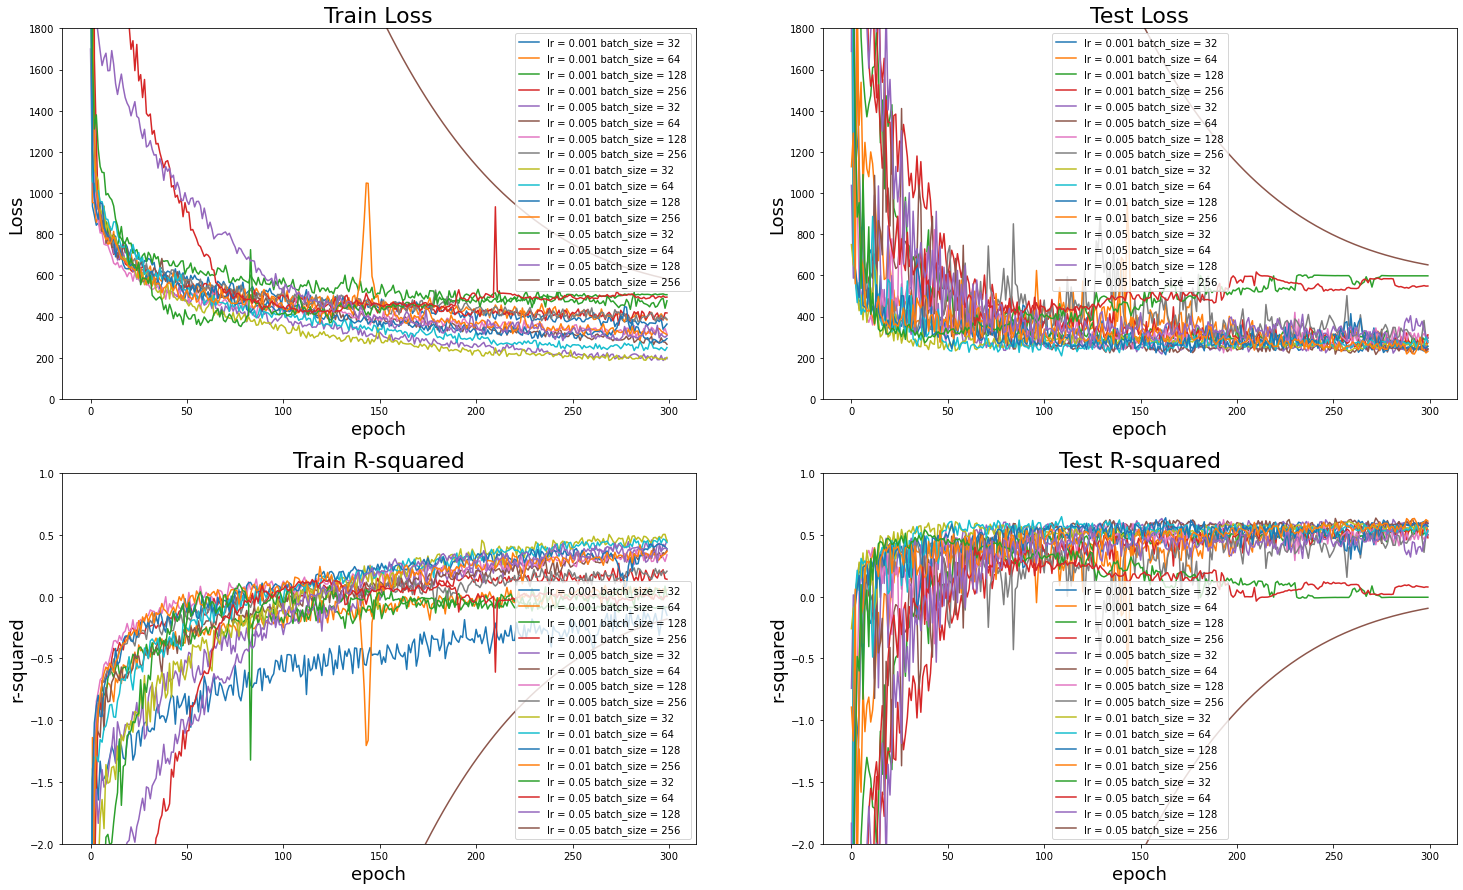

<Figure size 1800x1080 with 0 Axes>

In [23]:
def plot_all(ax, data_list):
    ax.plot(data_list[0],label="lr = 0.001 batch_size = 32")
    ax.plot(data_list[1],label="lr = 0.001 batch_size = 64")
    ax.plot(data_list[2],label="lr = 0.001 batch_size = 128")
    ax.plot(data_list[3],label="lr = 0.001 batch_size = 256")

    ax.plot(data_list[4],label="lr = 0.005 batch_size = 32")
    ax.plot(data_list[5],label="lr = 0.005 batch_size = 64")
    ax.plot(data_list[6],label="lr = 0.005 batch_size = 128")
    ax.plot(data_list[7],label="lr = 0.005 batch_size = 256")

    ax.plot(data_list[8],label="lr = 0.01 batch_size = 32")
    ax.plot(data_list[9],label="lr = 0.01 batch_size = 64")
    ax.plot(data_list[10],label="lr = 0.01 batch_size = 128")
    ax.plot(data_list[11],label="lr = 0.01 batch_size = 256")

    ax.plot(data_list[12],label="lr = 0.05 batch_size = 32")
    ax.plot(data_list[13],label="lr = 0.05 batch_size = 64")
    ax.plot(data_list[14],label="lr = 0.05 batch_size = 128")
    ax.plot(data_list[15],label="lr = 0.05 batch_size = 256")

figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure(figsize=(25,15))
ax1.set_title("Train Loss", fontsize=22)
plot_all(ax1, train_losses_all)
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("Loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 1800])

ax2.set_title("Test Loss", fontsize=22)
plot_all(ax2, test_losses_all)
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("Loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 1800])

ax3.set_title("Train R-squared", fontsize=22)
plot_all(ax3, train_accs_all)
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-2,1])

ax4.set_title("Test R-squared", fontsize=22)
plot_all(ax4, test_accs_all)
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squared", fontsize=18)
ax4.legend()
ax4.set_ylim([-2,1])

plt.show()

In [24]:
for data in train_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in test_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in train_losses_all:
    print(data[-1])

print("___________________\n")

for data in test_losses_all:
    print(data[-1])   
    

-0.14979638672178433
0.055550571644701535
0.004266671616598179
0.14128161723910598
0.45631699924117997
0.37636606652834403
0.3386497343073227
0.20665297122492227
0.44774149420695514
0.43761534520907125
0.38817231654004297
0.3661666941866238
-0.08609907547582869
0.0024911259072513976
0.38422993172118597
-0.18081733067245928
___________________

0.5911773033077996
0.542097867800676
0.5013216617258616
0.47665920477714474
0.5992298308511337
0.5922249961588616
0.5365666572575792
0.5242301172249477
0.571223289505487
0.534703812581037
0.5691525691064293
0.6118161874672345
-0.004298115858996976
0.07860765077013054
0.5033342333491839
-0.09386461310231597
___________________

364.24821213544425
384.4491938273112
477.0985493977865
418.0937919616699
195.8856996439271
266.0558603922526
316.3761271158854
388.29501724243164
202.1820068359375
249.89128570556642
293.70953267415365
312.0619812011719
506.8094391903635
495.11607411702477
308.3264912923177
583.6056137084961
___________________

243.5615386

### 2 best models

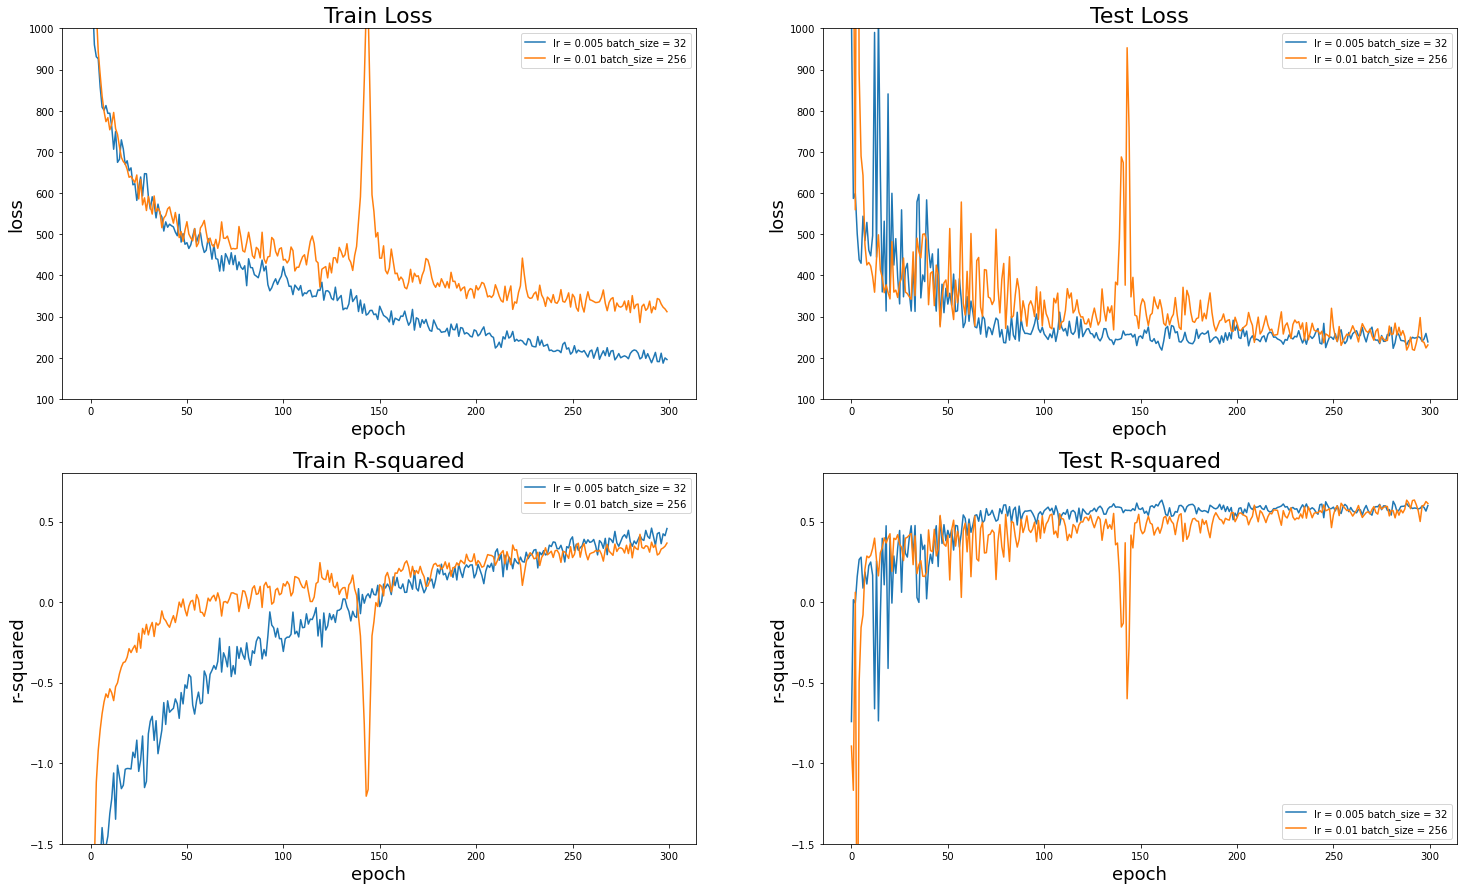

<Figure size 432x288 with 0 Axes>

In [29]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure()
ax1.set_title("Train Loss", fontsize=22)
ax1.plot(train_losses_all[4],label="lr = 0.005 batch_size = 32")
ax1.plot(train_losses_all[11],label="lr = 0.01 batch_size = 256")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([100, 1000])

ax2.set_title("Test Loss", fontsize=22)
ax2.plot(test_losses_all[4],label="lr = 0.005 batch_size = 32")
ax2.plot(test_losses_all[11],label="lr = 0.01 batch_size = 256")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("loss", fontsize=18)
ax2.legend()
ax2.set_ylim([100, 1000])

ax3.set_title("Train R-squared", fontsize=22)
ax3.plot(train_accs_all[4],label="lr = 0.005 batch_size = 32")
ax3.plot(train_accs_all[11],label="lr = 0.01 batch_size = 256")
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-1.5,0.8])

ax4.set_title("Test R-squared", fontsize=22)
ax4.plot(test_accs_all[4],label="lr = 0.005 batch_size = 32")
ax4.plot(test_accs_all[11],label="lr = 0.01 batch_size = 256")
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squared", fontsize=18)
ax4.legend()
ax4.set_ylim([-1.5,0.8])
plt.show()

## 4.2. Training

In [30]:
train_dataset = TensorDataset(torch.FloatTensor(X_train_all.values), torch.FloatTensor(y_train_all.values.reshape(-1, 1)))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(torch.FloatTensor(X_test.values), torch.FloatTensor(y_test.values.reshape(-1, 1)))
test_loader = DataLoader(test_dataset, batch_size=533, shuffle=False)

In [31]:
model = FCNN()
model.cuda()

epochs = 300
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.005)

train_losses = []
test_losses = []
train_accs = []
test_accs = []

best_value = 1000
best_params = {'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
writer = SummaryWriter()

for epoch in range(1, epochs + 1):
    
    print('################## EPOCH {} ##################'.format(epoch))
    
    model.train()
    train_correct = 0
    train_loss = 0

    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
            
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_acc = train_correct/len(train_loader)
    train_accs.append(train_acc)
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("R2/train", train_acc, epoch)
    print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))
    
    model.eval()
    
    test_loss = 0
    test_correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += criterion(output, target).item()
            test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
        
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_acc =test_correct/len(test_loader)
    test_accs.append(test_acc)

    if test_loss<best_value:
        best_value = test_loss
        torch.save(model.state_dict(), '../../models/protein_pubchem_fcnn_model.pt')
        best_params['epoch'] = epoch
        best_params['train_loss'] = train_loss
        best_params['test_loss'] = test_loss
        best_params['train_acc'] = train_acc
        best_params['test_acc'] = test_acc 
    writer.add_scalar("Loss/test", test_loss, epoch)
    writer.add_scalar("R2/test", test_acc, epoch)

    print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

writer.flush()
writer.close()

print(best_params)

################## EPOCH 1 ##################
Train Avg. loss: 1855.0316772460938, Accuracy: -4.176890189980901
Test Avg. loss: 1302.7657470703125, Accuracy: -1.8230039560763855
################## EPOCH 2 ##################
Train Avg. loss: 1134.7043675664645, Accuracy: -2.1777397869938366
Test Avg. loss: 686.2847290039062, Accuracy: -0.4871319371009746
################## EPOCH 3 ##################
Train Avg. loss: 1071.112319718546, Accuracy: -2.1103640164593256
Test Avg. loss: 623.1412963867188, Accuracy: -0.35030450441370875
################## EPOCH 4 ##################
Train Avg. loss: 979.7767625495569, Accuracy: -1.872742564888326
Test Avg. loss: 377.4261779785156, Accuracy: 0.18214331428158792
################## EPOCH 5 ##################
Train Avg. loss: 919.2714064868528, Accuracy: -1.6600302324782623
Test Avg. loss: 457.40960693359375, Accuracy: 0.008824781251797975
################## EPOCH 6 ##################
Train Avg. loss: 1015.6265340776586, Accuracy: -2.183823918568984

Train Avg. loss: 555.0597247223355, Accuracy: -0.8449871645737311
Test Avg. loss: 285.5655212402344, Accuracy: 0.3811990930535146
################## EPOCH 49 ##################
Train Avg. loss: 586.439345174761, Accuracy: -0.8531192615770484
Test Avg. loss: 300.64862060546875, Accuracy: 0.3485150114977391
################## EPOCH 50 ##################
Train Avg. loss: 535.3121889028977, Accuracy: -0.6364066289469834
Test Avg. loss: 234.94810485839844, Accuracy: 0.49088357927363946
################## EPOCH 51 ##################
Train Avg. loss: 536.5717686895114, Accuracy: -0.6669612638343202
Test Avg. loss: 260.6562194824219, Accuracy: 0.43517583472199317
################## EPOCH 52 ##################
Train Avg. loss: 544.2686334866196, Accuracy: -0.580902027139266
Test Avg. loss: 223.63800048828125, Accuracy: 0.5153917688042136
################## EPOCH 53 ##################
Train Avg. loss: 523.2282632856227, Accuracy: -0.7000369084673113
Test Avg. loss: 244.73065185546875, Accuracy: 

Train Avg. loss: 420.18542890406366, Accuracy: -0.2548175016517394
Test Avg. loss: 310.34381103515625, Accuracy: 0.32750623434027104
################## EPOCH 96 ##################
Train Avg. loss: 428.17568741983445, Accuracy: -0.30411359897854184
Test Avg. loss: 229.78077697753906, Accuracy: 0.5020808287853922
################## EPOCH 97 ##################
Train Avg. loss: 426.2527415716826, Accuracy: -0.29621730517734857
Test Avg. loss: 251.89602661132812, Accuracy: 0.4541585797181805
################## EPOCH 98 ##################
Train Avg. loss: 429.1897296051481, Accuracy: -0.2909439707937399
Test Avg. loss: 225.13600158691406, Accuracy: 0.5121457013639663
################## EPOCH 99 ##################
Train Avg. loss: 431.24720969128964, Accuracy: -0.3664232195409499
Test Avg. loss: 223.1561737060547, Accuracy: 0.5164358612245452
################## EPOCH 100 ##################
Train Avg. loss: 434.3156572028772, Accuracy: -0.41034472324975396
Test Avg. loss: 260.6260681152344, Ac

Train Avg. loss: 333.52954056013874, Accuracy: -0.0640966221849817
Test Avg. loss: 229.63888549804688, Accuracy: 0.5023882767248335
################## EPOCH 142 ##################
Train Avg. loss: 357.53062575610716, Accuracy: -0.03167441922176906
Test Avg. loss: 250.57264709472656, Accuracy: 0.45702623539667353
################## EPOCH 143 ##################
Train Avg. loss: 358.18121292342, Accuracy: -0.08890328402115666
Test Avg. loss: 231.2289581298828, Accuracy: 0.4989426956980313
################## EPOCH 144 ##################
Train Avg. loss: 346.1339241141704, Accuracy: -0.05919867593827679
Test Avg. loss: 255.25973510742188, Accuracy: 0.4468696734163745
################## EPOCH 145 ##################
Train Avg. loss: 338.32408164864154, Accuracy: 0.001320380529401123
Test Avg. loss: 216.48561096191406, Accuracy: 0.530890552056801
################## EPOCH 146 ##################
Train Avg. loss: 341.62459188432837, Accuracy: 0.04849792805577171
Test Avg. loss: 246.40150451660156

Train Avg. loss: 307.8417770613485, Accuracy: 0.11602617472124642
Test Avg. loss: 206.3173828125, Accuracy: 0.5529243674376669
################## EPOCH 188 ##################
Train Avg. loss: 290.55552172304976, Accuracy: 0.18837317456261465
Test Avg. loss: 210.90762329101562, Accuracy: 0.5429776208935948
################## EPOCH 189 ##################
Train Avg. loss: 308.20745690189193, Accuracy: 0.08677236268967603
Test Avg. loss: 231.01210021972656, Accuracy: 0.49941260223547124
################## EPOCH 190 ##################
Train Avg. loss: 280.63800367668495, Accuracy: 0.15821651569307732
Test Avg. loss: 246.13148498535156, Accuracy: 0.4666499704045759
################## EPOCH 191 ##################
Train Avg. loss: 299.0170698023554, Accuracy: 0.1295156796864294
Test Avg. loss: 257.798095703125, Accuracy: 0.4413691799452911
################## EPOCH 192 ##################
Train Avg. loss: 307.1715493273379, Accuracy: 0.12607760442672705
Test Avg. loss: 228.58786010742188, Accura

Train Avg. loss: 271.031781780186, Accuracy: 0.23714333036215815
Test Avg. loss: 223.81968688964844, Accuracy: 0.5149980703509385
################## EPOCH 234 ##################
Train Avg. loss: 266.976000429979, Accuracy: 0.24993022810030863
Test Avg. loss: 218.3709259033203, Accuracy: 0.5268052087819787
################## EPOCH 235 ##################
Train Avg. loss: 271.58883211505946, Accuracy: 0.22706326075475716
Test Avg. loss: 199.2504119873047, Accuracy: 0.5682380444796469
################## EPOCH 236 ##################
Train Avg. loss: 248.1713149796671, Accuracy: 0.30725985061478095
Test Avg. loss: 214.26007080078125, Accuracy: 0.5357131205345658
################## EPOCH 237 ##################
Train Avg. loss: 255.2137297445269, Accuracy: 0.25384306422090314
Test Avg. loss: 219.30845642089844, Accuracy: 0.5247736189376235
################## EPOCH 238 ##################
Train Avg. loss: 264.76896337252947, Accuracy: 0.27011589235787864
Test Avg. loss: 224.3633270263672, Accura

Train Avg. loss: 214.36822384506908, Accuracy: 0.4006136652298858
Test Avg. loss: 198.24765014648438, Accuracy: 0.5704109291735625
################## EPOCH 280 ##################
Train Avg. loss: 223.07906797038976, Accuracy: 0.36861774246443374
Test Avg. loss: 204.56678771972656, Accuracy: 0.5567178286133405
################## EPOCH 281 ##################
Train Avg. loss: 203.83753192958548, Accuracy: 0.40272025920156185
Test Avg. loss: 209.131103515625, Accuracy: 0.5468272816252837
################## EPOCH 282 ##################
Train Avg. loss: 215.0776227125481, Accuracy: 0.3985854791587178
Test Avg. loss: 209.7119140625, Accuracy: 0.5455686664551845
################## EPOCH 283 ##################
Train Avg. loss: 205.00736600961258, Accuracy: 0.4393391476806445
Test Avg. loss: 202.4859161376953, Accuracy: 0.5612269040615174
################## EPOCH 284 ##################
Train Avg. loss: 208.84311288862085, Accuracy: 0.4289432903244435
Test Avg. loss: 201.4659881591797, Accuracy: 

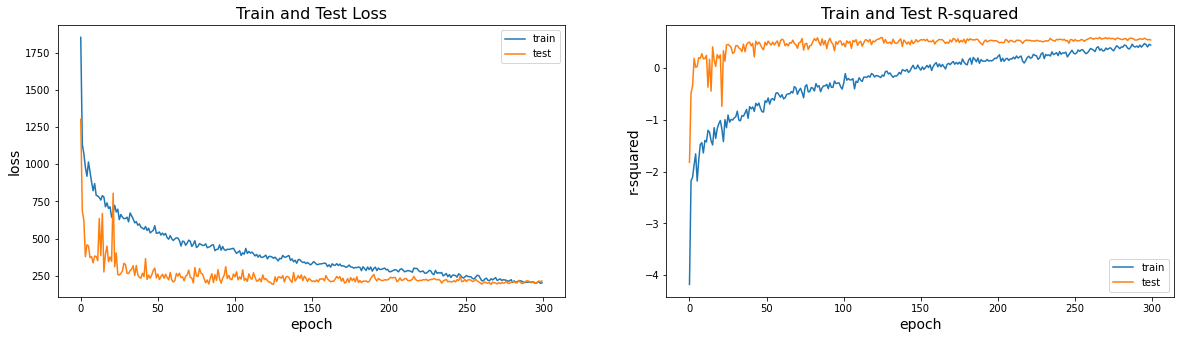

<Figure size 1440x360 with 0 Axes>

In [33]:
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
plt.figure(figsize=(20,5))
ax1.set_title("Train and Test Loss", fontsize=16)
ax1.plot(train_losses,label="train")
ax1.plot(test_losses,label="test")
ax1.set_xlabel("epoch", fontsize=14)
ax1.set_ylabel("loss", fontsize=14)
ax1.legend()

ax2.set_title("Train and Test R-squared", fontsize=16)
ax2.plot(train_accs,label="train")
ax2.plot(test_accs,label="test")
ax2.set_xlabel("epoch", fontsize=14)
ax2.set_ylabel("r-squared", fontsize=14)
ax2.legend()
plt.show()

In [34]:
model = FCNN()
model.load_state_dict(torch.load('../../models/protein_pubchem_fcnn_model.pt'))
model.cuda()
model.eval()

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        predictons = output.cpu().detach().numpy()
        print_evaluate(target.cpu().detach().numpy(), predictons)

MAE: 8.992935
MSE: 190.65736
RMSE: 13.807874
R2 Square 0.5868585672258262 

